# Import Packages
Import the packages needed for building, training and using machine learning models

In [1]:
pip install tensorflow_addons

In [2]:
import os

import librosa
import librosa.display
import scipy.io.wavfile as wav
from scipy.optimize import linear_sum_assignment

import numpy as np
import random
from sklearn import preprocessing
from sklearn.metrics import multilabel_confusion_matrix
import joblib
from collections import deque

import tensorflow as tf
from tensorflow_addons.image import sparse_image_warp
import time

from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Activation
from tensorflow.keras.layers import LSTM, GRU, Dropout, Reshape, Dense, Lambda, TimeDistributed, Bidirectional
from tensorflow.keras.layers import RepeatVector, Permute, multiply
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import seaborn as sns

<br></br>
# Mount Google Drive

In [3]:
# connect to google drive for dataset
# I stored the dataset in google drive to enable me build and train the ML model in google colab
# Please replace the working directory (working_dir) variable with the path to the folder that contains ipymb file on your computer or your google drive

from google.colab import drive
drive.mount('/content/drive')

working_dir = '/content/drive/My Drive/Colab Notebooks/Applications of Machine Learning/Assignment/SELD/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<br></br>
# Feature Extraction

## FeatureClass - handles the feature extraction

In [4]:
# This class handles all operations that concern the features, their parameters and extraction
class FeatureClass:
  def __init__(self, dataset_dir='', feat_label_dir='', dataset='foa'):
    """
    :param dataset_dir: location of the folder that holds the dataset
    :param feat_label_dir: location of folder that will hold the extracted features and labels
    :param dataset: string, dataset name, supported: foa - ambisonic
    """

    # Input directories
    self._feat_label_dir = feat_label_dir # location of folder that will hold the extracted features and labels
    self._dataset_dir = dataset_dir # location of the folder that holds the dataset
    self._dataset_combination = '{}_dev'.format(dataset)
    self._aud_dir = os.path.join(self._dataset_dir, self._dataset_combination) # path to audio files for audio type

    self._desc_dir = os.path.join(self._dataset_dir, 'metadata_dev') # location of metadata that holds the labels of the audio files

    # Output directories
    self._label_dir = None # folder that holds only the labels
    self._feat_dir = None # folder that holds only unnormalized features
    self._feat_dir_norm = None # folder that holds normalized features

    # This is the sample rate of the audio files (number of values in one second)
    # So audio file has length_in_seconds x sample_rate values
    self._fs = 48000

    self._hop_len_s = 0.02 # 20ms --> When generating feature, move window from left to right using this hop length
    self._hop_len = int(self._fs * self._hop_len_s) # 960 --> number of samples in the 0.02 hop length (this is the hop length in samples instead of seconds)
    self._frame_res = self._fs / float(self._hop_len) # 50 --> number of hops in one second of audio
    self._nb_frames_1s = int(self._frame_res)

    self._win_len = 2 * self._hop_len # 1920 --> length of the window to process per time (over_lap = window - hop_length)
    self._nfft = self._next_greater_power_of_2(self._win_len) # 2048 -->  length of the windowed signal after padding with zeros (win_len <= n_fft)

    # parameters for generating log-mel spectrum and IV
    self._nb_mel_bins=64
    self._mel_wts = librosa.filters.mel(sr=self._fs, n_fft=self._nfft, n_mels=self._nb_mel_bins).T

    self._dataset = dataset
    self._eps = np.spacing(np.float(1e-16))
    self._nb_channels = 4 # number of audio channels

    # Sound event classes dictionary # DCASE 2016 Task 2 sound events
    self._unique_classes = dict()
    self._unique_classes = \
        {
            'clearthroat': 2,
            'cough': 8,
            'doorslam': 9,
            'drawer': 1,
            'keyboard': 6,
            'keysDrop': 4,
            'knock': 0,
            'laughter': 10,
            'pageturn': 7,
            'phone': 3,
            'speech': 5
        }

    self._doa_resolution = 10 # doas values are in intervals of 10 degress
    self._azi_list = range(-180, 180, self._doa_resolution) # list of all possible azimuth values
    self._length = len(self._azi_list) # number of all possible azimuth value
    self._ele_list = range(-40, 50, self._doa_resolution) # list of all possible elevation values

    self._audio_max_len_samples = 60 * self._fs # 2880000

    self._default_azi = 180
    self._default_ele = 50

    if self._default_azi in self._azi_list:
        print('ERROR: chosen default_azi value {} should not exist in azi_list'.format(self._default_azi))
        exit()
    if self._default_ele in self._ele_list:
        print('ERROR: chosen default_ele value {} should not exist in ele_list'.format(self._default_ele))
        exit()

    self._max_frames = int(np.ceil(self._audio_max_len_samples / float(self._hop_len))) # 3000 -> maximum number of frames expected in our extracted features

  def _load_audio(self, audio_path):
    fs, audio = wav.read(audio_path) # read audio
    audio = audio[:, :self._nb_channels] / 32768.0 + self._eps # normalize values
    if audio.shape[0] < self._audio_max_len_samples:
      zero_pad = np.zeros((self._audio_max_len_samples - audio.shape[0], audio.shape[1]))
      audio = np.vstack((audio, zero_pad)) # pad audio to make it as long as the maximum allowed length
    elif audio.shape[0] > self._audio_max_len_samples:
      audio = audio[:self._audio_max_len_samples, :] # extract maximum allowed length from the audio file
    return audio, fs

  # INPUT FEATURES
  @staticmethod
  def _next_greater_power_of_2(x):
    return 2 ** (x - 1).bit_length()

  def _spectrogram(self, audio_input):
    _nb_ch = audio_input.shape[1] # number of channels in audio recording
    nb_bins = self._nfft // 2
    spectra = np.zeros((self._max_frames, nb_bins + 1, _nb_ch), dtype=complex)
    for ch_cnt in range(_nb_ch):
      stft_ch = librosa.core.stft(np.asfortranarray(audio_input[:, ch_cnt]), n_fft=self._nfft, hop_length=self._hop_len,
                                    win_length=self._win_len, window='hann') # get spectrogram for each audio channel
      spectra[:, :, ch_cnt] = stft_ch[:, :self._max_frames].T
    return spectra

  def _get_spectrogram_for_file(self, audio_filename):
    audio_in, fs = self._load_audio(os.path.join(self._aud_dir, audio_filename))
    audio_spec = self._spectrogram(audio_in)
    return audio_spec

  def _get_mel_spectrogram(self, linear_spectra):
    mel_feat = np.zeros((linear_spectra.shape[0], self._nb_mel_bins, linear_spectra.shape[-1]))
    for ch_cnt in range(linear_spectra.shape[-1]):
        mag_spectra = np.abs(linear_spectra[:, :, ch_cnt])**2
        mel_spectra = np.dot(mag_spectra, self._mel_wts)
        log_mel_spectra = librosa.power_to_db(mel_spectra)
        mel_feat[:, :, ch_cnt] = log_mel_spectra
    mel_feat = mel_feat.reshape((linear_spectra.shape[0], self._nb_mel_bins * linear_spectra.shape[-1]))
    return mel_feat

  def _get_foa_intensity_vectors(self, linear_spectra):
    IVx = np.real(np.conj(linear_spectra[:, :, 0]) * linear_spectra[:, :, 3])
    IVy = np.real(np.conj(linear_spectra[:, :, 0]) * linear_spectra[:, :, 1])
    IVz = np.real(np.conj(linear_spectra[:, :, 0]) * linear_spectra[:, :, 2])

    normal = np.sqrt(IVx**2 + IVy**2 + IVz**2) + self._eps
    IVx = np.dot(IVx / normal, self._mel_wts)
    IVy = np.dot(IVy / normal, self._mel_wts)
    IVz = np.dot(IVz / normal, self._mel_wts)

    # we are doing the following instead of simply concatenating to keep the processing similar to mel_spec and gcc
    foa_iv = np.dstack((IVx, IVy, IVz))
    foa_iv = foa_iv.reshape((linear_spectra.shape[0], self._nb_mel_bins * 3))
    if np.isnan(foa_iv).any():
        print('Feature extraction is generating nan outputs')
        exit()
    return foa_iv



  # OUTPUT LABELS
  def read_desc_file(self, desc_filename, in_sec=False):
    # extract labels from metadata file
    desc_file = {
        'class': list(), 'start': list(), 'end': list(), 'ele': list(), 'azi': list()
    }
    fid = open(desc_filename, 'r')
    next(fid)
    for line in fid:
        split_line = line.strip().split(',')
        desc_file['class'].append(split_line[0])
        if in_sec:
            # return onset-offset time in seconds
            desc_file['start'].append(float(split_line[1]))
            desc_file['end'].append(float(split_line[2]))
        else:
            # return onset-offset time in frames
            desc_file['start'].append(int(np.floor(float(split_line[1])*self._frame_res)))
            desc_file['end'].append(int(np.ceil(float(split_line[2])*self._frame_res)))
        desc_file['ele'].append(int(split_line[3]))
        desc_file['azi'].append(int(split_line[4]))
    fid.close()
    return desc_file

  def _get_doa_labels_regr(self, _desc_file):
    # create arrays for azimth and elevation angles. Insert default values
    azi_label = self._default_azi*np.ones((self._max_frames, len(self._unique_classes))) # 3000, 11
    ele_label = self._default_ele*np.ones((self._max_frames, len(self._unique_classes))) # 3000, 11
    for i, ele_ang in enumerate(_desc_file['ele']):
        start_frame = _desc_file['start'][i]
        end_frame = self._max_frames if _desc_file['end'][i] > self._max_frames else _desc_file['end'][i]
        azi_ang = _desc_file['azi'][i]
        class_ind = self._unique_classes[_desc_file['class'][i]]
        # if value is within permitted rangle then insert value into the frame range (rows) of the active class (column)
        if (azi_ang >= self._azi_list[0]) and (azi_ang <= self._azi_list[-1]) and (ele_ang >= self._ele_list[0]) and (ele_ang <= self._ele_list[-1]):
            azi_label[start_frame:end_frame + 1, class_ind] = azi_ang
            ele_label[start_frame:end_frame + 1, class_ind] = ele_ang
        else:
            print('bad_angle {} {}'.format(azi_ang, ele_ang))
    doa_label_regr = np.concatenate((azi_label, ele_label), axis=1) # return item of shape 3000, 22
    return doa_label_regr

  def _get_se_labels(self, _desc_file):
    # create an array of (3000, 11) with all values as 0
    se_label = np.zeros((self._max_frames, len(self._unique_classes)))

    # since we have the start and end frames for the active sound
    # we fill in those array spaces with 1 (rows of start to end frame, column of active class)
    for i, se_class in enumerate(_desc_file['class']):
        start_frame = _desc_file['start'][i]
        end_frame = self._max_frames if _desc_file['end'][i] > self._max_frames else _desc_file['end'][i]
        se_label[start_frame:end_frame + 1, self._unique_classes[se_class]] = 1
    return se_label

  def get_labels_for_file(self, _desc_file):
    """
    Reads description csv file and returns classification based SED labels and regression based DOA labels

    :param _desc_file: csv file
    :return: label_mat: labels of the format [sed_label, doa_label],
    where sed_label is of dimension [nb_frames, nb_classes] which is 1 for active sound event else zero
    where doa_labels is of dimension [nb_frames, 2*nb_classes], nb_classes each for azimuth and elevation angles,
    if active, the DOA values will be in degrees, else, it will contain default doa values given by
    self._default_ele and self._default_azi
    """

    se_label = self._get_se_labels(_desc_file)
    doa_label = self._get_doa_labels_regr(_desc_file)

    # place SE and DOA arrays side by side (because they have the same number of rows -> max_frame)
    label_mat = np.concatenate((se_label, doa_label), axis=1)
    return label_mat # 3000, 33

  # ------------------------------- EXTRACT FEATURE AND PREPROCESS IT -------------------------------
  def extract_all_feature(self):
    # setting up folders
    self._feat_dir = self.get_unnormalized_feat_dir()
    create_folder(self._feat_dir)

    # extraction starts
    print('Extracting spectrogram:')
    print('\t\taud_dir {}\n\t\tdesc_dir {}\n\t\tfeat_dir {}'.format(
        self._aud_dir, self._desc_dir, self._feat_dir))

    for file_cnt, file_name in enumerate(os.listdir(self._aud_dir)):
        wav_filename = '{}.wav'.format(file_name.split('.')[0])
        spect = self._get_spectrogram_for_file(wav_filename)

        #extract mel
        mel_spect = self._get_mel_spectrogram(spect) # 3000, 256

        # extract intensity vectors
        foa_iv = self._get_foa_intensity_vectors(spect)  # 3000, 192
        feat = np.concatenate((mel_spect, foa_iv), axis=-1)

        print('{}: {}, {}'.format(file_cnt, file_name, feat.shape )) # feat.shape --> 3000, 448 --> (3000 frames with 448 features)
        np.save(os.path.join(self._feat_dir, '{}.npy'.format(wav_filename.split('.')[0])), feat)

  def augment_mel(self):
    # setting up folders
    self._feat_dir = self.get_unnormalized_feat_dir()
    self._feat_dir_norm = self.get_normalized_feat_dir()

    # setup normalization files
    normalized_features_wts_file = self.get_normalized_wts_file()
    spec_scaler = joblib.load(normalized_features_wts_file)

    print('--- Augmentation started ---')

    sample = ()
    all_feature_files = os.listdir(self._feat_dir)
    # run data augmentations equally across all splits
    count = 0
    for i in range(0, 4):
      split_feature_files = list(filter(lambda x: (x[5] == "{}".format(i + 1)), all_feature_files))
      aug_arr = np.random.randint(0, len(split_feature_files) - 1, size = len(split_feature_files)//4) # array of random indexes to augment
      for file_cnt, file_index in enumerate(aug_arr):
        count += 1
        file_name = split_feature_files[file_index]
        feat_file = np.load(os.path.join(self._feat_dir, file_name))
        # print("{}. {} was augmented and duplicated".format(file_cnt + 1, feature_files[file_index]))

        # separate features
        mel_spec = feat_file[:, :(self._nb_mel_bins * self._nb_channels)]
        foa_iv = feat_file[:, (self._nb_mel_bins * self._nb_channels):]

        # augment mel_spec
        mel_spec_after_freq_mk = self.freq_mask(mel_spec, param=20)
        mel_spec_after_time_mk = self.time_mask(mel_spec_after_freq_mk, param=20)

        # join features
        feat = np.concatenate((mel_spec_after_time_mk, foa_iv), axis=-1)

        # scale and save normlized features
        feat = spec_scaler.transform(feat)
        new_file_name = "{}_{}.npy".format(file_name.split('.')[0], "aug")
        np.save(os.path.join(self._feat_dir_norm, new_file_name),feat)

        # save accompanying label
        non_aug_label = np.load(os.path.join(self.get_label_dir(), file_name)) # load
        np.save(os.path.join(self.get_label_dir(), new_file_name), non_aug_label) # save with new name

        # return mel spectrogram of last augmented features
        if (i == 3 and file_cnt == len(aug_arr) - 1):
          sample = (np.transpose(mel_spec), np.transpose(mel_spec_after_time_mk.numpy()))
      print ("Number of created augmented files in split {}: {}".format(i+1, len(aug_arr)))
    return sample


  def freq_mask(self, input, param, name=None):
    """
    Apply masking to a spectrogram in the freq domain.
    """
    input = tf.convert_to_tensor(input)
    freq_max = tf.shape(input)[1] # 256
    for i in range(0, 2):
      f = tf.random.uniform(shape=(), minval=0, maxval=param, dtype=tf.dtypes.int32)
      f0 = tf.random.uniform(
          shape=(), minval=0, maxval=freq_max - f, dtype=tf.dtypes.int32
      )
      indices = tf.reshape(tf.range(freq_max), (1, -1))
      condition = tf.math.logical_and(
          tf.math.greater_equal(indices, f0), tf.math.less(indices, f0 + f)
      )
      input = tf.where(condition, tf.cast(0, input.dtype), input)
    return input


  def time_mask(self, input, param, name=None):
    """
    Apply masking to a spectrogram in the time domain.
    """
    input = tf.convert_to_tensor(input)
    time_max = tf.shape(input)[0]
    for i in range(0, 2):
      t = tf.random.uniform(shape=(), minval=0, maxval=param, dtype=tf.dtypes.int32)
      t0 = tf.random.uniform(
          shape=(), minval=0, maxval=time_max - t, dtype=tf.dtypes.int32
      )
      indices = tf.reshape(tf.range(time_max), (-1, 1))
      condition = tf.math.logical_and(
          tf.math.greater_equal(indices, t0), tf.math.less(indices, t0 + t)
      )
      input = tf.where(condition, tf.cast(0, input.dtype), input)
    return input


  def preprocess_features(self):
    # Setting up folders and filenames
    self._feat_dir = self.get_unnormalized_feat_dir()
    self._feat_dir_norm = self.get_normalized_feat_dir()
    create_folder(self._feat_dir_norm)
    normalized_features_wts_file = self.get_normalized_wts_file()
    spec_scaler = None

    # pre-processing starts
    print('Estimating weights for normalizing feature files:')
    print('\t\tfeat_dir: {}'.format(self._feat_dir))

    spec_scaler = preprocessing.StandardScaler()
    for file_cnt, file_name in enumerate(os.listdir(self._feat_dir)):
        print('{}: {}'.format(file_cnt, file_name))
        feat_file = np.load(os.path.join(self._feat_dir, file_name))

        # fit -> get mean and std from all data set
        # part_fit -> we already have mean and std but also consider this value in the calculationn
        #             It is helpful when saving memory, so that we dont have to load all the data at once
        spec_scaler.partial_fit(feat_file)
        del feat_file
    joblib.dump(
        spec_scaler,
        normalized_features_wts_file
    )
    print('Normalized_features_wts_file: {}. Saved.'.format(normalized_features_wts_file))

    print('Normalizing feature files:')
    print('\t\tfeat_dir_norm {}'.format(self._feat_dir_norm))
    for file_cnt, file_name in enumerate(os.listdir(self._feat_dir)):
        print('{}: {}'.format(file_cnt, file_name))
        feat_file = np.load(os.path.join(self._feat_dir, file_name))
        feat_file = spec_scaler.transform(feat_file)
        np.save(
            os.path.join(self._feat_dir_norm, file_name),
            feat_file
        )
        del feat_file

    print('normalized files written to {}'.format(self._feat_dir_norm))



  # ------------------------------- EXTRACT LABELS AND PREPROCESS IT -------------------------------
  def extract_all_labels(self):
      self._label_dir = self.get_label_dir()

      print('Extracting labels:')
      print('\t\taud_dir {}\n\t\tdesc_dir {}\n\t\tlabel_dir {}'.format(
          self._aud_dir, self._desc_dir, self._label_dir))
      create_folder(self._label_dir)

      for file_cnt, file_name in enumerate(os.listdir(self._desc_dir)):
          print('{}: {}'.format(file_cnt, file_name))
          wav_filename = '{}.wav'.format(file_name.split('.')[0])
          desc_file = self.read_desc_file(os.path.join(self._desc_dir, file_name))
          label_mat = self.get_labels_for_file(desc_file)
          np.save(os.path.join(self._label_dir, '{}.npy'.format(wav_filename.split('.')[0])), label_mat)



  # ------------------------------- Misc public functions -------------------------------
  def get_classes(self):
      return self._unique_classes

  def get_normalized_feat_dir(self):
      return os.path.join(
          self._feat_label_dir,
          '{}_norm'.format(self._dataset_combination)
      )

  def get_unnormalized_feat_dir(self):
      return os.path.join(
          self._feat_label_dir,
          '{}'.format(self._dataset_combination)
      )

  def get_label_dir(self):
      return os.path.join(
          self._feat_label_dir, '{}_label'.format(self._dataset_combination)
      )

  def get_normalized_wts_file(self):
      return os.path.join(
          self._feat_label_dir,
          '{}_wts'.format(self._dataset)
      )

  def get_default_azi_ele_regr(self):
      return self._default_azi, self._default_ele

  def nb_frames_1s(self):
      return self._nb_frames_1s

  def get_nb_mel_bins(self):
      return self._nb_mel_bins
  
  def get_sample_rate(self):
      return self._fs
  
  def get_hop_len(self):
      return self._hop_len

def create_folder(folder_name):
  if not os.path.exists(folder_name):
        print('{} folder does not exist, creating it.'.format(folder_name))
        os.makedirs(folder_name)

## Batch Extractor
This is run once to extract all needed features from the audio files. The mel spectrogram and intensity vectors are extracted as the features of the audio files

In [ ]:
dataset_dir = os.path.join(working_dir, 'dataset/')   # Base folder containing the foa and metadata folders
feat_label_dir = os.path.join(working_dir, 'dataset/feat_label/')  # Directory to dump extracted features and labels


# -------------- Extract features and labels for development set -----------------------------
dev_feat_cls = FeatureClass(dataset_dir=dataset_dir, feat_label_dir=feat_label_dir)

# Extract features and normalize them
dev_feat_cls.extract_all_feature() # saves extracted features
dev_feat_cls.preprocess_features() # saves scaled features

# Extract labels for training data set
dev_feat_cls.extract_all_labels()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Extracting spectrogram:
		aud_dir /content/drive/My Drive/Colab Notebooks/Applications of Machine Learning/Assignment/SELD/dataset/foa_dev
		desc_dir /content/drive/My Drive/Colab Notebooks/Applications of Machine Learning/Assignment/SELD/dataset/metadata_dev
		feat_dir /content/drive/My Drive/Colab Notebooks/Applications of Machine Learning/Assignment/SELD/dataset/feat_label/foa_dev
0: split1_ir0_ov1_1.wav, (3000, 448)
1: split1_ir0_ov1_10.wav, (3000, 448)
2: split1_ir0_ov1_2.wav, (3000, 448)
3: split1_ir0_ov1_3.wav, (3000, 448)
4: split1_ir0_ov1_4.wav, (3000, 448)
5: split1_ir0_ov1_5.wav, (3000, 448)
6: split1_ir0_ov1_6.wav, (3000, 448)
7: split1_ir0_ov1_7.wav, (3000, 448)
8: split1_ir0_ov1_8.wav, (3000, 448)
9: split1_ir0_ov1_9.wav, (3000, 448)
10: split1_ir0_ov2_11.wav, (3000, 448)
11: split1_ir0_ov2_12.wav, (3000, 448)
12: split1_ir0_ov2_13.wav, (3000, 448)
13: split1_ir0_ov2_14.wav, (3000, 448)
14: split1_ir0_ov2_15.wav, (3000, 448)
15: split1_ir0_ov2_16.wav, (3000, 448)
16: spli

In [ ]:
# Perform data augmentation to increase files by 25%
sample_feature = dev_feat_cls.augment_mel()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


--- Augmentation started ---
Number of created augmented files in split 1: 25
Number of created augmented files in split 2: 25
Number of created augmented files in split 3: 25
Number of created augmented files in split 4: 25


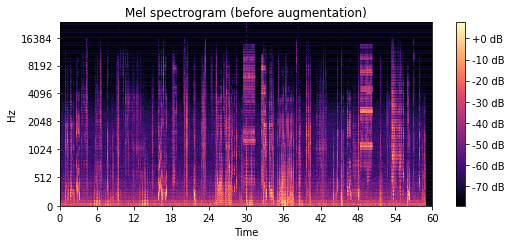

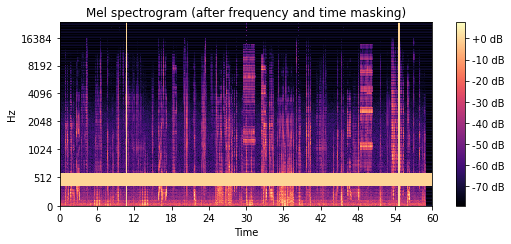

In [ ]:
# Show sample feature before and after augmentation
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

fig, ax = plt.subplots()
img = librosa.display.specshow(sample_feature[0], x_axis='time', y_axis='mel', ax=ax, sr=dev_feat_cls.get_sample_rate(), hop_length=dev_feat_cls.get_hop_len())
ax.set(title='Mel spectrogram (before augmentation)')
fig.colorbar(img, ax=ax, format="%+2.f dB")

fig, ax = plt.subplots()
img = librosa.display.specshow(sample_feature[1], x_axis='time', y_axis='mel', ax=ax, sr=dev_feat_cls.get_sample_rate(), hop_length=dev_feat_cls.get_hop_len())
ax.set(title='Mel spectrogram (after frequency and time masking)')
fig.colorbar(img, ax=ax, format="%+2.f dB")

<br></br>
# Evaluation Metrics

In [5]:
###############################################################
# SED scoring functions
###############################################################
eps = np.finfo(float).eps

def reshape_3Dto2D(A):
    return A.reshape(A.shape[0] * A.shape[1], A.shape[2])


def f1_overall_framewise(O, T):
    if len(O.shape) == 3:
        O, T = reshape_3Dto2D(O), reshape_3Dto2D(T)
    TP = ((2 * T - O) == 1).sum() # multiplying a true value (represented by 1) by 2 and subtracting predicted value will give 1, any other combination gives values other than 1
    Nref, Nsys = T.sum(), O.sum()

    prec = float(TP) / float(Nsys + eps)
    recall = float(TP) / float(Nref + eps)
    f1_score = 2 * prec * recall / (prec + recall + eps)
    return f1_score


def er_overall_framewise(O, T):
    if len(O.shape) == 3:
        O, T = reshape_3Dto2D(O), reshape_3Dto2D(T)

    FP = np.logical_and(T == 0, O == 1).sum(1)
    FN = np.logical_and(T == 1, O == 0).sum(1)

    S = np.minimum(FP, FN).sum()
    D = np.maximum(0, FN-FP).sum()
    I = np.maximum(0, FP-FN).sum()

    Nref = T.sum()
    ER = (S+D+I) / (Nref + 0.0)
    return ER


def f1_overall_1sec(O, T, block_size):
    if len(O.shape) == 3:
        O, T = reshape_3Dto2D(O), reshape_3Dto2D(T)
    new_size = int(np.ceil(float(O.shape[0]) / block_size))
    O_block = np.zeros((new_size, O.shape[1]))
    T_block = np.zeros((new_size, O.shape[1]))
    for i in range(0, new_size):
        O_block[i, :] = np.max(O[int(i * block_size):int(i * block_size + block_size - 1), :], axis=0) # get maximum predicted values for all classes within the blocksize
        T_block[i, :] = np.max(T[int(i * block_size):int(i * block_size + block_size - 1), :], axis=0) # get maximum truth values for all classes within the blocksize
    return f1_overall_framewise(O_block, T_block)


def er_overall_1sec(O, T, block_size):
    if len(O.shape) == 3:
        O, T = reshape_3Dto2D(O), reshape_3Dto2D(T)
    new_size = int(np.ceil(float(O.shape[0]) / block_size))
    O_block = np.zeros((new_size, O.shape[1]))
    T_block = np.zeros((new_size, O.shape[1]))
    for i in range(0, new_size):
        O_block[i, :] = np.max(O[int(i * block_size):int(i * block_size + block_size - 1), :], axis=0)
        T_block[i, :] = np.max(T[int(i * block_size):int(i * block_size + block_size - 1), :], axis=0)
    return er_overall_framewise(O_block, T_block)


def compute_sed_scores(pred, gt, nb_frames_1s):
    """
    Computes SED metrics for one second segments

    :param pred: predicted matrix of dimension [nb_frames, nb_classes], with 1 when sound event is active else 0
    :param gt:  reference matrix of dimension [nb_frames, nb_classes], with 1 when sound event is active else 0
    :param nb_frames_1s: integer, number of frames in one second
    :return:
    """
    f1o = f1_overall_1sec(pred, gt, nb_frames_1s)
    ero = er_overall_1sec(pred, gt, nb_frames_1s)
    scores = [ero, f1o]
    return scores


###############################################################
# DOA scoring functions
###############################################################


def compute_doa_scores_regr(pred_doa_rad, gt_doa_rad, pred_sed, gt_sed):
    """
        Compute DOA metrics when DOA is estimated using regression approach

    :param pred_doa_rad: predicted doa_labels is of dimension [nb_frames, 2*nb_classes],
                        nb_classes each for azimuth and elevation angles,
                        if active, the DOA values will be in RADIANS, else, it will contain default doa values
    :param gt_doa_rad: reference doa_labels is of dimension [nb_frames, 2*nb_classes],
                    nb_classes each for azimuth and elevation angles,
                    if active, the DOA values will be in RADIANS, else, it will contain default doa values
    :param pred_sed: predicted sed label of dimension [nb_frames, nb_classes] which is 1 for active sound event else zero
    :param gt_sed: reference sed label of dimension [nb_frames, nb_classes] which is 1 for active sound event else zero
    :return:
    """

    nb_src_gt_list = np.zeros(gt_doa_rad.shape[0]).astype(int) # array of size 4096 (32 x 128) with zeros
    nb_src_pred_list = np.zeros(gt_doa_rad.shape[0]).astype(int) # array of size 4096 (32 x 128) with zeros
    good_frame_cnt = 0
    doa_loss_pred = 0.0
    nb_sed = gt_sed.shape[-1] # 11

    less_est_cnt, less_est_frame_cnt = 0, 0
    more_est_cnt, more_est_frame_cnt = 0, 0

    foundCount = 0
    for frame_cnt, sed_frame in enumerate(gt_sed):
        nb_src_gt_list[frame_cnt] = int(np.sum(sed_frame))
        nb_src_pred_list[frame_cnt] = int(np.sum(pred_sed[frame_cnt]))

        '''if frame_cnt > 5 and frame_cnt < 10:
            print("Segment ", (frame_cnt + 1))
            print("Sum of truth: ", nb_src_gt_list[frame_cnt])
            print("Sum of pred: ", nb_src_pred_list[frame_cnt])'''

        ## good_frame_cnt includes frames where the nb active sources were zero in both groundtruth and prediction

        # good_frame_cnt --> 2956 --> counts frames in the prediction and ground truth that both say there is no sound or the same number of sounds
        # less_est_frame_cnt --> 1140 --> counts how many frames in the truth have more active sounds that the predicted
        # less_est_cnt --> 1140 --> counts the number of active events missed by the prediction
        # more_est_frame_cnt --> 0 --> counts how many frames in the truth have less active sounds that the predicted
        # more_est_cnt --> 0 --> counts the number of active events predicted above the truth

        if nb_src_gt_list[frame_cnt] == nb_src_pred_list[frame_cnt]:
            good_frame_cnt = good_frame_cnt + 1
        elif nb_src_gt_list[frame_cnt] > nb_src_pred_list[frame_cnt]:
            less_est_cnt = less_est_cnt + nb_src_gt_list[frame_cnt] - nb_src_pred_list[frame_cnt]
            less_est_frame_cnt = less_est_frame_cnt + 1
        elif nb_src_gt_list[frame_cnt] < nb_src_pred_list[frame_cnt]:
            more_est_cnt = more_est_cnt + nb_src_pred_list[frame_cnt] - nb_src_gt_list[frame_cnt]
            more_est_frame_cnt = more_est_frame_cnt + 1

        # when nb_ref_doa > nb_estimated_doa, ignores the extra ref doas and scores only the nearest matching doas
        # similarly, when nb_estimated_doa > nb_ref_doa, ignores the extra estimated doa and scores the remaining matching doas

        # if the truth (for this frame) has active sounds and the prediction also has then calculate the following
        if nb_src_gt_list[frame_cnt] and nb_src_pred_list[frame_cnt]:
            # DOA Loss with respect to predicted confidence
            sed_frame_gt = gt_sed[frame_cnt]
            doa_frame_gt_azi = gt_doa_rad[frame_cnt][:nb_sed][sed_frame_gt == 1] # get the azimuth of the detected event in the ground truth
            doa_frame_gt_ele = gt_doa_rad[frame_cnt][nb_sed:][sed_frame_gt == 1] # get the elevation of the detected event in the ground truth

            sed_frame_pred = pred_sed[frame_cnt]
            doa_frame_pred_azi = pred_doa_rad[frame_cnt][:nb_sed][sed_frame_pred == 1] # get the azimuth of the detected event in the prediction
            doa_frame_pred_ele = pred_doa_rad[frame_cnt][nb_sed:][sed_frame_pred == 1] # get the elevation of the detected event in the prediction

            doa_loss_pred += distance_between_gt_pred(np.vstack((doa_frame_gt_azi, doa_frame_gt_ele)).T,
                                                      np.vstack((doa_frame_pred_azi, doa_frame_pred_ele)).T)


    doa_loss_pred_cnt = np.sum(nb_src_pred_list)
    if doa_loss_pred_cnt:
        doa_loss_pred /= doa_loss_pred_cnt

    frame_recall = good_frame_cnt / float(gt_sed.shape[0])
    er_metric = [doa_loss_pred, frame_recall, doa_loss_pred_cnt, good_frame_cnt, more_est_cnt, less_est_cnt]
    return er_metric


def distance_between_gt_pred(gt_list_rad, pred_list_rad):
    """
    Shortest distance between two sets of spherical coordinates. Given a set of groundtruth spherical coordinates,
     and its respective predicted coordinates, we calculate the spherical distance between each of the spherical
     coordinate pairs resulting in a matrix of distances, where one axis represents the number of groundtruth
     coordinates and the other the predicted coordinates. The number of estimated peaks need not be the same as in
     groundtruth, thus the distance matrix is not always a square matrix. We use the hungarian algorithm to find the
     least cost in this distance matrix.

    :param gt_list_rad: list of ground-truth spherical coordinates
    :param pred_list_rad: list of predicted spherical coordinates
    :return: cost -  distance
    :return: less - number of DOA's missed
    :return: extra - number of DOA's over-estimated
    """

    gt_len, pred_len = gt_list_rad.shape[0], pred_list_rad.shape[0]
    ind_pairs = np.array([[x, y] for y in range(pred_len) for x in range(gt_len)])
    cost_mat = np.zeros((gt_len, pred_len))

    if gt_len and pred_len:
        az1, ele1, az2, ele2 = gt_list_rad[ind_pairs[:, 0], 0], gt_list_rad[ind_pairs[:, 0], 1], \
                               pred_list_rad[ind_pairs[:, 1], 0], pred_list_rad[ind_pairs[:, 1], 1]
        cost_mat[ind_pairs[:, 0], ind_pairs[:, 1]] = distance_between_spherical_coordinates_rad(az1, ele1, az2, ele2)

    row_ind, col_ind = linear_sum_assignment(cost_mat)
    cost = cost_mat[row_ind, col_ind].sum()
    return cost


def distance_between_spherical_coordinates_rad(az1, ele1, az2, ele2):
    """
    Angular distance between two spherical coordinates
    MORE: https://en.wikipedia.org/wiki/Great-circle_distance

    :return: angular distance in degrees
    """
    dist = np.sin(ele1) * np.sin(ele2) + np.cos(ele1) * np.cos(ele2) * np.cos(np.abs(az1 - az2))
    # Making sure the dist values are in -1 to 1 range, else np.arccos kills the job
    dist = np.clip(dist, -1, 1)
    dist = np.arccos(dist) * 180 / np.pi
    return dist


###############################################################
# SELD scoring functions
###############################################################


def compute_seld_metric(sed_error, doa_error):
    """
    Compute SELD metric from sed and doa errors.

    :param sed_error: [error rate (0 to 1 range), f score (0 to 1 range)]
    :param doa_error: [doa error (in degrees), frame recall (0 to 1 range)]
    :return: seld metric result
    """
    seld_metric = np.mean([
        sed_error[0],
        1 - sed_error[1],
        doa_error[0]/180,
        1 - doa_error[1]]
        )
    return seld_metric


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


<br></br>
# Data Generator

In [6]:
#
# This class is responsible for genrating the dataset for training, validation and testing
#

class DataGenerator(object):
    def __init__(
            self, dataset='foa', feat_label_dir='', split=1, batch_size=32, seq_len=64,
            shuffle=True, per_file=False
    ):
        self._per_file = per_file
        self._splits = np.array(split)
        self._batch_size = batch_size # 16
        self._seq_len = seq_len # 128 --> number of frames to process per time
        self._shuffle = shuffle
        self._feat_cls = FeatureClass(feat_label_dir=feat_label_dir, dataset=dataset)
        self._label_dir = self._feat_cls.get_label_dir()
        self._feat_dir = self._feat_cls.get_normalized_feat_dir()

        self._filenames_list = list()
        self._nb_frames_file = 0     # 3000 --> Using a fixed number of frames in feat files. Updated in _get_label_filenames_sizes()

        self._nb_mel_bins = self._feat_cls.get_nb_mel_bins()
        self._nb_ch = None

        self._label_len = None  # total length of label - DOA + SED
        self._doa_len = None    # DOA label length
        self._class_dict = self._feat_cls.get_classes()
        self._nb_classes = len(self._class_dict.keys())
        self._default_azi, self._default_ele = self._feat_cls.get_default_azi_ele_regr()
        self._get_filenames_list_and_feat_label_sizes()

        self._batch_seq_len = self._batch_size*self._seq_len #2048
        self._circ_buf_feat = None
        self._circ_buf_label = None

        # get total number of batches for this split
        if self._per_file:
            self._nb_total_batches = len(self._filenames_list)
        else:
            self._nb_total_batches = int(np.floor((len(self._filenames_list) * self._nb_frames_file /
                                               float(self._seq_len * self._batch_size)))) # 146 --> 100 files with 3000 frames, sequence length of 128 and batch size of 16

        print(
            '\tDatagen_mode: {}, nb_files: {}, nb_classes:{}\n'
            '\tnb_frames_file: {}, feat_len: {}, nb_ch: {}, label_len:{}\n'.format(
                'dev', len(self._filenames_list),  self._nb_classes,
                self._nb_frames_file, self._nb_mel_bins, self._nb_ch, self._label_len
                )
        )

        print(
            '\tDataset: {}, split: {}\n'
            '\tbatch_size: {}, seq_len: {}, shuffle: {}\n'
            '\tTotal batches in dataset: {}\n'
            '\tlabel_dir: {}\n '
            '\tfeat_dir: {}\n'.format(
                dataset, split,
                self._batch_size, self._seq_len, self._shuffle,
                self._nb_total_batches,
                self._label_dir, self._feat_dir
            )
        )

    def get_data_sizes(self):
        feat_shape = (self._batch_size, self._nb_ch, self._seq_len, self._nb_mel_bins)
        label_shape = [
            (self._batch_size, self._seq_len, self._nb_classes),
            (self._batch_size, self._seq_len, self._nb_classes*2)
        ]
        # feat_shape = batch_size, 7, sequence_length, feature_length = 16,8,128,64
        # label_shape = (batch_size, sequence_length, class_count), (batch_size, sequence_length, class_count * 2)= (16,128,11),(16,128,22)
        return feat_shape, label_shape

    def get_total_batches_in_data(self):
        return self._nb_total_batches

    def _get_filenames_list_and_feat_label_sizes(self):
        # only take files in the specified split
        for filename in os.listdir(self._feat_dir):
            if int(filename[5]) in self._splits: # check which split the file belongs to
                self._filenames_list.append(filename)

        # get number of frames in a sample audio (feature extraction)
        temp_feat = np.load(os.path.join(self._feat_dir, self._filenames_list[0]))
        self._nb_frames_file = temp_feat.shape[0]
        self._nb_ch = temp_feat.shape[1] // self._nb_mel_bins # 448 / 64 = 7 --> so each extracted feature has 7 channels
        
        temp_label = np.load(os.path.join(self._label_dir, self._filenames_list[0])) # get label for a sample audio
        self._label_len = temp_label.shape[-1] # get the length of the labels (sed and doa[azi & ele] -> class*3) # 33
        self._doa_len = (self._label_len - self._nb_classes)//self._nb_classes # 2 (if there are 11 classes)

        if self._per_file:
            self._batch_size = int(np.ceil(temp_feat.shape[0]/float(self._seq_len)))

        return

    def generate(self):
        """
        Generates batches of samples
        :return: 
        """

        while 1:
            if self._shuffle:
                random.shuffle(self._filenames_list)

            self._circ_buf_feat = deque()
            self._circ_buf_label = deque()

            file_cnt = 0
            # Batch Sequence Length: 2048 (128 * 16) (seq_len * batch_size) 
            # Total Batches: 366 (number of files in batch * frames_per_file / batch_sequence_length) (250 * 3000 / 2048) --> if split uses two sets of training files
            for i in range(self._nb_total_batches):
                
                # load feat and label to circular buffer. Always maintain atleast one batch worth feat and label in the
                # circular buffer. If not keep refilling it.
                while len(self._circ_buf_feat) < self._batch_seq_len:
                    temp_feat = np.load(os.path.join(self._feat_dir, self._filenames_list[file_cnt]))
                    temp_label = np.load(os.path.join(self._label_dir, self._filenames_list[file_cnt]))

                    # iterate through all 3000 frames by 448 ( 448 is 64 mel bins by 7 features; 4 for mel and 3 for intensity) in the file
                    # add the frame info (mag and phase features for all channels)
                    # add the label info (33 which is 11 for SED and 22 for DOA)
                    for row_cnt, row in enumerate(temp_feat):
                        self._circ_buf_feat.append(row)
                        self._circ_buf_label.append(temp_label[row_cnt])

                    # If self._per_file is True, this returns the sequences belonging to a single audio recording
                    if self._per_file:
                        extra_frames = self._batch_seq_len - temp_feat.shape[0]
                        extra_feat = np.ones((extra_frames, temp_feat.shape[1])) * 1e-6

                        extra_labels = np.zeros((extra_frames, temp_label.shape[1]))
                        extra_labels[:, self._nb_classes:2 * self._nb_classes] = self._default_azi
                        extra_labels[:, 2 * self._nb_classes:] = self._default_ele

                        for row_cnt, row in enumerate(extra_feat):
                            self._circ_buf_feat.append(row)
                            self._circ_buf_label.append(extra_labels[row_cnt])

                    file_cnt = file_cnt + 1

                # Read one batch size from the circular buffer
                # feat -> extract batch -> (2048, 448) instead of the full 3000, 8192
                # label -> extract batch -> (2048, 33) instead of the full 3000, 33
                feat = np.zeros((self._batch_seq_len, self._nb_mel_bins * self._nb_ch))
                label = np.zeros((self._batch_seq_len, self._label_len))
                for j in range(self._batch_seq_len):
                    feat[j, :] = self._circ_buf_feat.popleft()
                    label[j, :] = self._circ_buf_label.popleft()
                feat = np.reshape(feat, (self._batch_seq_len, self._nb_mel_bins, self._nb_ch))
                # feat -> 2048, 64, 7

                # Split to sequences
                feat = self._split_in_seqs(feat)
                # feat -> 16, 128, 64, 7

                label = self._split_in_seqs(label)
                # label -> 16, 128, 33

                # Get azi/ele in radians
                # Normalize azi values and convert it to rad
                azi_rad = label[:, :, self._nb_classes:2 * self._nb_classes] * np.pi / self._default_azi

                # rescaling the elevation data from [-def_elevation def_elevation] to [-180 180] to keep them in the
                # range of azimuth angle
                ele_rad = label[:, :, 2 * self._nb_classes:] * np.pi / self._default_ele

                label = [
                    label[:, :, :self._nb_classes],  # SED labels
                    np.concatenate((azi_rad, ele_rad), -1)  # DOA labels in radians
                      ]

                yield feat, label

    def _split_in_seqs(self, data):
        if len(data.shape) == 1:
            if data.shape[0] % self._seq_len:
                data = data[:-(data.shape[0] % self._seq_len), :]
            data = data.reshape((data.shape[0] // self._seq_len, self._seq_len, 1))
        elif len(data.shape) == 2:
            if data.shape[0] % self._seq_len:
                data = data[:-(data.shape[0] % self._seq_len), :]
            data = data.reshape((data.shape[0] // self._seq_len, self._seq_len, data.shape[1]))
        elif len(data.shape) == 3:
            if data.shape[0] % self._seq_len:
                data = data[:-(data.shape[0] % self._seq_len), :, :]
            data = data.reshape((data.shape[0] // self._seq_len, self._seq_len, data.shape[1], data.shape[2]))
        else:
            print('ERROR: Unknown data dimensions: {}'.format(data.shape))
            exit()
        return data

    def get_default_elevation(self):
        return self._default_ele

    def get_azi_ele_list(self):
        return self._feat_cls.get_azi_ele_list()

    def get_nb_classes(self):
        return self._nb_classes

    def nb_frames_1s(self):
        return self._feat_cls.nb_frames_1s()


<br></br>
# CRNN Models

## CRNN (CNN + LSTM/GRU)

In [7]:
def get_crnn_model(rnn_type, attention, data_in, data_out, dropout_rate, nb_cnn2d_filt, f_pool_size, t_pool_size,
                                rnn_size, fnn_size, weights):
  # model definition
  # Passed Input shape -> 16, 7, 128, 64

  spec_start = Input(shape=(data_in[-2], data_in[-1], data_in[-3]))
  # Network Input shape ->128, 164, 7

  # CNN - add convolutional layers
  spec_cnn = spec_start
  for i, convCnt in enumerate(f_pool_size):
    spec_cnn = Conv2D(filters=nb_cnn2d_filt[i], kernel_size=(3, 3), padding='same')(spec_cnn)
    spec_cnn = BatchNormalization()(spec_cnn) # add batch normalization layer
    spec_cnn = Activation('relu')(spec_cnn) # use relu activation function
    spec_cnn = MaxPooling2D(pool_size=(t_pool_size[i], f_pool_size[i]))(spec_cnn) # downsample alogn the frequency dimension only
    spec_cnn = Dropout(dropout_rate)(spec_cnn)
  # output shape of CNN is (None, 128, 2, 64)

  # RNN
  spec_rnn = Reshape((data_in[-2], -1))(spec_cnn) # reshape input
  # After reshape (None, 128, 256)
  if attention == True:
    spec_rnn = attention_block(spec_rnn) # pass extracted features into attention block
  for nb_rnn_filt in rnn_size:
    if rnn_type == "lstm":
      spec_rnn = Bidirectional(
          LSTM(nb_rnn_filt, activation='tanh', dropout=dropout_rate, return_sequences=True),
          merge_mode='mul'
      )(spec_rnn)
    else:
      spec_rnn = Bidirectional(
          GRU(nb_rnn_filt, activation='tanh', dropout=dropout_rate, return_sequences=True),
          merge_mode='mul'
      )(spec_rnn)

  # FC - DOA
  doa = spec_rnn
  for nb_fnn_filt in fnn_size:
      doa = TimeDistributed(Dense(nb_fnn_filt))(doa) # share weights across time
      doa = Dropout(dropout_rate)(doa)

  doa = TimeDistributed(Dense(data_out[1][-1]))(doa)
  doa = Activation('linear', name='doa_out')(doa) # no non-linear activation is needed for a regression task

  # FC - SED
  sed = spec_rnn
  for nb_fnn_filt in fnn_size:
      sed = TimeDistributed(Dense(nb_fnn_filt))(sed)
      sed = Dropout(dropout_rate)(sed)
  sed = TimeDistributed(Dense(data_out[0][-1]))(sed)
  sed = Activation('sigmoid', name='sed_out')(sed)

  model = Model(inputs=spec_start, outputs=[sed, doa])
  model.compile(optimizer=Adam(), loss=['binary_crossentropy', 'mse'], loss_weights=weights)

  model.summary()
  return model

def attention_block(inputs):
  # inputs.shape = (batch_size, time_steps, input_dim)
  input_dim = int(inputs.shape[2])
  timestep = int(inputs.shape[1])
  a = Permute((2, 1))(inputs) #Permutes the dimensions of the input according to a given pattern.
  a = Dense(timestep, activation='softmax')(a) #// Alignment Model + Softmax
  a = Lambda(lambda x: keras.backend.mean(x, axis=1), name='dim_reduction')(a)
  a = RepeatVector(input_dim)(a)
  a_probs = Permute((2, 1), name='attention_vec')(a)
  output_attention_mul = multiply([inputs, a_probs], name='attention_mul') #// Weighted Average 
  return output_attention_mul

## CRNN (CNN + LSTM) with Attenion

In [8]:
# This model was not used as it used up all allocated memory on google colab
keras.backend.set_image_data_format('channels_last')

verbose = 0

@tf.keras.utils.register_keras_serializable()
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units, verbose=0, **kwargs):
        super(BahdanauAttention, self).__init__(**kwargs)
        self.units = units
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        self.verbose= verbose

    def get_config(self):
        config = super(BahdanauAttention, self).get_config()
        config.update({
            "units": self.units,
            "verbose": self.verbose
        })
        return config

    def call(self, query, values):
        if self.verbose:
            print('\n******* Bahdanau Attention STARTS******')
            print('query (decoder hidden state): (batch_size, hidden size) ', query.shape)
            print('values (encoder all hidden state): (batch_size, max_len, hidden size) ', values.shape)

        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)
        
        if self.verbose:
            print('query_with_time_axis:(batch_size, 1, hidden size) ', query_with_time_axis.shape)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))
        if self.verbose:
            print('score: (batch_size, max_length, 1) ',score.shape)
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        if self.verbose:
            print('attention_weights: (batch_size, max_length, 1) ',attention_weights.shape)
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        if self.verbose:
            print('context_vector before reduce_sum: (batch_size, max_length, hidden_size) ',context_vector.shape)
        context_vector = tf.reduce_sum(context_vector, axis=1)
        if self.verbose:
            print('context_vector after reduce_sum: (batch_size, hidden_size) ',context_vector.shape)
            print('\n******* Bahdanau Attention ENDS******')
        return context_vector, attention_weights


class CRNNAttentionModel:
    def __init__(self, data_in, data_out, dropout_rate, nb_cnn2d_filt, f_pool_size, t_pool_size, rnn_size, fnn_size, weights):
        self._data_in = data_in
        self._data_out = data_out
        self._dropout_rate = dropout_rate
        self._nb_cnn2d_filt = nb_cnn2d_filt
        self._f_pool_size = f_pool_size
        self._t_pool_size = t_pool_size
        self._rnn_size = rnn_size
        self._fnn_size = fnn_size
        self._weights = weights

        self._batch_size = data_in[0]
        self._sequence_length = data_in[2]

    def setup_decoder(self, n_features, attention, encoder_outputs, encoder_states, branch_name):
        # Set up the decoder layers
        print("\n Setup decoder layer for ", branch_name)
        decoder_lstm = LSTM(self._rnn_size[0],  return_state=True, name='{}_decoder_lstm'.format(branch_name))
        if branch_name == 'sed':
          decoder_dense = Dense(n_features, activation='sigmoid',  name='{}_decoder_dense'.format(branch_name))
        else:
          decoder_dense = Dense(n_features, activation='linear',  name='{}_decoder_dense'.format(branch_name))
        all_outputs = []

        # 1 initial decoder's input data
        inputs = np.zeros((self._batch_size, 1, n_features), dtype=np.float32)
        inputs[:, 0, 0] = 1 


        # 2 initial decoder's state
        # encoder's last hidden state + last cell state
        decoder_outputs = encoder_states[0] #encoder_state_h
        states = encoder_states

        # decoder will only process one time step at a time.
        print("\n Creating time steps for ", branch_name)
        count = 0
        for _ in range(self._sequence_length):
            count += 1
            if (count % 16 == 0):
              print("Step {} of {}".format(count, self._sequence_length))

            # Pay attention
            # create the context vector by applying attention to 
            # decoder_outputs (last hidden state) + encoder_outputs (all hidden states)
            context_vector, attention_weights=attention(decoder_outputs, encoder_outputs)
            '''if verbose:
                print("\nAttention context_vector: (batch size, units) {}".format(context_vector.shape))
                print("Attention weights : (batch_size, sequence_length, 1) {}".format(attention_weights.shape))
                print('decoder_outputs: (batch_size,  latentSpaceDimension) ', decoder_outputs.shape )'''

            context_vector = tf.expand_dims(context_vector, 1)
            '''if verbose:
                print('Reshaped context_vector: ', context_vector.shape )'''

            # concatenate the input + context vectore to find the next decoder's input
            inputs = tf.concat([context_vector, inputs], axis=-1)
            del context_vector
            
            '''if verbose:
                print('After concat inputs: (batch_size, 1, n_features + hidden_size): ',inputs.shape )'''

            # Passing the concatenated vector to the LSTM
            # Run the decoder on one timestep with attended input and previous states
            decoder_outputs, state_h, state_c = decoder_lstm(inputs, initial_state=states)
            #decoder_outputs = tf.reshape(decoder_outputs, (-1, decoder_outputs.shape[2]))
            del inputs
    
            # Use the last hidden state for prediction the output
            # save the current prediction
            # we will concatenate all predictions later
            outputs = decoder_outputs
            # del decoder_outputs
            for nb_fnn_filt in self._fnn_size:
                doa = Dense(nb_fnn_filt)(outputs)
                doa = Dropout(self._dropout_rate)(outputs)
            outputs = decoder_dense(outputs)
            outputs = tf.expand_dims(outputs, 1)
            all_outputs.append(outputs)


            # Reinject the output (prediction) as inputs for the next loop iteration
            # as well as update the states
            inputs = outputs
            states = [state_h, state_c]
            del outputs
            del state_h
            del state_c

        # After running Decoder for max time steps
        # we had created a predition list for the output sequence
        # convert the list to output array by Concatenating all predictions 
        # such as [batch_size, timesteps, features]
        decoder_outputs = Lambda(merge_outputs, name='{}_decoder_lambda'.format(branch_name))(all_outputs)

        print("Decoder Output Shape: ", decoder_outputs.shape)

        return decoder_outputs

    def create_model(self):
        #--- ENCODER ----
        # Encoder CNN
        encoder_inputs = Input(shape=(self._sequence_length, self._data_in[3], self._data_in[1]), name='encoder_inputs')
        spec_cnn = encoder_inputs
        for i, convCnt in enumerate(self._f_pool_size):
            spec_cnn = Conv2D(filters=self._nb_cnn2d_filt[i], kernel_size=(3, 3), padding='same')(spec_cnn)
            spec_cnn = BatchNormalization()(spec_cnn)
            spec_cnn = Activation('relu')(spec_cnn)
            spec_cnn = MaxPooling2D(pool_size=(self._t_pool_size[i], self._f_pool_size[i]))(spec_cnn)
            spec_cnn = Dropout(self._dropout_rate)(spec_cnn)
        spec_cnn_end = Reshape((self._sequence_length, -1))(spec_cnn) # From (128, 2, 64) becomes (128, 128)

        # Encoder RNN
        encoder_lstm = LSTM(self._rnn_size[0], return_sequences=True, return_state=True,  name='encoder_lstm')
        encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(spec_cnn_end)

        # initial context vector is the states of the encoder
        encoder_states = [encoder_state_h, encoder_state_c]

        # Set up the attention layer
        attention = BahdanauAttention(self._rnn_size[0], verbose=verbose)

        # Decode layers for SED tasks
        sed_decoder_output = self.setup_decoder(self._data_out[0][-1], attention, encoder_outputs, encoder_states, "sed")
        doa_decoder_output = self.setup_decoder(self._data_out[1][-1], attention, encoder_outputs, encoder_states, "doa")

        # 9. Define and compile model 
        print("\n Finishing model")
        model = Model(inputs=encoder_inputs, outputs=[sed_decoder_output, doa_decoder_output], name='model_encoder_decoder')
        model.compile(optimizer=Adam(), loss=['binary_crossentropy', 'mse'], loss_weights=self._weights)
        model.summary()

        return model


def merge_outputs(x):    
    from keras import backend as K
    return K.concatenate(x, axis=1)




## CRNN (CNN + LSTM) with Attention for SED

In [9]:
# please run previous code cell before this cell
# The BahdanauAttention class is created in the previous code cell
# The "merge_outputs" function is also implemented in the previous code cell

# This model was not used as it used up all allocated memory on google colab

verbose = 0

class CRNNPartialAttentionModel:
    def __init__(self, data_in, data_out, dropout_rate, nb_cnn2d_filt, f_pool_size, t_pool_size, rnn_size, fnn_size, weights):
        self._data_in = data_in
        self._data_out = data_out
        self._dropout_rate = dropout_rate
        self._nb_cnn2d_filt = nb_cnn2d_filt
        self._f_pool_size = f_pool_size
        self._t_pool_size = t_pool_size
        self._rnn_size = rnn_size
        self._fnn_size = fnn_size
        self._weights = weights

        self._batch_size = data_in[0]
        self._sequence_length = data_in[2]

    def setup_decoder(self, n_features, attention, encoder_outputs, encoder_states, branch_name):
        # Set up the decoder layers
        print("\n Setup decoder layer for ", branch_name)
        decoder_lstm = LSTM(self._rnn_size[0],  return_state=True, name='{}_decoder_lstm'.format(branch_name))
        if branch_name == 'sed':
          decoder_dense = Dense(n_features, activation='sigmoid',  name='{}_decoder_dense'.format(branch_name))
        else:
          decoder_dense = Dense(n_features, activation='linear',  name='{}_decoder_dense'.format(branch_name))
        all_outputs = []

        # 1 initial decoder's input data
        # Prepare initial decoder input data that just contains the start character 
        # Note that we made it a constant one-hot-encoded in the model
        # that is, [1 0 0 0 0 0 0 0 0 0] is the first input for each loop
        # one-hot encoded zero(0) is the start symbol
        inputs = np.zeros((self._batch_size, 1, n_features), dtype=np.float32)
        inputs[:, 0, 0] = 1 


        # 2 initial decoder's state
        # encoder's last hidden state + last cell state
        decoder_outputs = encoder_states[0] #encoder_state_h
        states = encoder_states

        # decoder will only process one time step at a time.
        print("\n Creating time steps for ", branch_name)
        count = 0
        for _ in range(self._sequence_length):
            count += 1
            if (count % 16 == 0):
              print("Step {} of {}".format(count, self._sequence_length))

            # Pay attention
            # create the context vector by applying attention to 
            # decoder_outputs (last hidden state) + encoder_outputs (all hidden states)
            context_vector, attention_weights=attention(decoder_outputs, encoder_outputs)
            if verbose:
                '''print("\nAttention context_vector: (batch size, units) {}".format(context_vector.shape))
                print("Attention weights : (batch_size, sequence_length, 1) {}".format(attention_weights.shape))
                print('decoder_outputs: (batch_size,  latentSpaceDimension) ', decoder_outputs.shape )'''

            context_vector = tf.expand_dims(context_vector, 1)
            '''if verbose:
                print('Reshaped context_vector: ', context_vector.shape )'''

            # concatenate the input + context vectore to find the next decoder's input
            inputs = tf.concat([context_vector, inputs], axis=-1)
            
            '''if verbose:
                print('After concat inputs: (batch_size, 1, n_features + hidden_size): ',inputs.shape )'''

            # Passing the concatenated vector to the LSTM
            # Run the decoder on one timestep with attended input and previous states
            decoder_outputs, state_h, state_c = decoder_lstm(inputs, initial_state=states)
            #decoder_outputs = tf.reshape(decoder_outputs, (-1, decoder_outputs.shape[2]))
    
            # Use the last hidden state for prediction the output
            # save the current prediction
            # we will concatenate all predictions later
            # former code - outputs = decoder_dense(decoder_outputs)
            outputs = decoder_outputs
            for nb_fnn_filt in self._fnn_size:
                doa = Dense(nb_fnn_filt)(outputs)
                doa = Dropout(self._dropout_rate)(outputs)
            outputs = decoder_dense(outputs)
            outputs = tf.expand_dims(outputs, 1)
            all_outputs.append(outputs)


            # Reinject the output (prediction) as inputs for the next loop iteration
            # as well as update the states
            inputs = outputs
            states = [state_h, state_c]

        # After running Decoder for max time steps
        # we had created a predition list for the output sequence
        # convert the list to output array by Concatenating all predictions 
        # such as [batch_size, timesteps, features]
        decoder_outputs = Lambda(merge_outputs, name='{}_decoder_lambda'.format(branch_name))(all_outputs)

        print("Decoder Output Shape: ", decoder_outputs.shape)

        return decoder_outputs

    def create_model(self):
        #--- ENCODER ----
        # Encoder CNN
        encoder_inputs = Input(shape=(self._sequence_length, self._data_in[3], self._data_in[1]), name='encoder_inputs')
        spec_cnn = encoder_inputs
        for i, convCnt in enumerate(self._f_pool_size):
            spec_cnn = Conv2D(filters=self._nb_cnn2d_filt[i], kernel_size=(3, 3), padding='same')(spec_cnn)
            spec_cnn = BatchNormalization()(spec_cnn)
            spec_cnn = Activation('relu')(spec_cnn)
            spec_cnn = MaxPooling2D(pool_size=(self._t_pool_size[i], self._f_pool_size[i]))(spec_cnn)
            spec_cnn = Dropout(self._dropout_rate)(spec_cnn)
        spec_cnn_end = Reshape((self._sequence_length, -1))(spec_cnn) # From (128, 2, 64) becomes (128, 128)

        # Encoder RNN
        encoder_lstm = LSTM(self._rnn_size[0], activation='tanh', dropout=self._dropout_rate, recurrent_dropout=self._dropout_rate, return_sequences=True, return_state=True,  name='encoder_lstm')
        encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(spec_cnn_end)

        # initial context vector is the states of the encoder
        encoder_states = [encoder_state_h, encoder_state_c]

        # Set up the attention layer
        attention = BahdanauAttention(self._rnn_size[0], verbose=verbose)

        # Decode layers for SED tasks
        sed_decoder_output = self.setup_decoder(self._data_out[0][-1], attention, encoder_outputs, encoder_states, "sed")

        # FC - DOA
        spec_rnn = Bidirectional(
            LSTM(self._rnn_size[1], activation='tanh', dropout=self._dropout_rate, recurrent_dropout=self._dropout_rate,return_sequences=True, return_state=False),
            merge_mode='mul'
        )(encoder_outputs)
        doa = spec_rnn
        for nb_fnn_filt in self._fnn_size:
            doa = TimeDistributed(Dense(nb_fnn_filt))(doa)
            doa = Dropout(self._dropout_rate)(doa)
        doa = TimeDistributed(Dense(self._data_out[1][-1]))(doa)
        doa = Activation('linear', name='doa_out')(doa)

        # Define and compile model
        model = Model(inputs=encoder_inputs, outputs=[sed_decoder_output, doa], name='model_encoder_decoder')
        model.compile(optimizer=Adam(), loss=['binary_crossentropy', 'mse'], loss_weights=self._weights)
        model.summary()

        return model


<br></br>
# Model Creation & Training Helpers

## Helper Functions

In [10]:
def get_params(argv):
    print("SET: {}".format(argv))
    # ########### default parameters ##############
    params = dict(
        quick_test=False,     # To do quick test. Trains/test on small subset of dataset, and # of epochs

        # INPUT PATH
        dataset_dir = os.path.join(working_dir, 'dataset/'),   # Base folder containing the foa and metadata folders

        # OUTPUT PATH
        feat_label_dir = os.path.join(working_dir, 'dataset/feat_label/'),  # Directory to dump extracted features and labels
        model_dir = os.path.join(working_dir, 'models/'),   # Dumps the trained models and training curves in this folder
        dcase_output=False,     # If true, dumps the results recording-wise in 'dcase_dir' path.
                               # Set this true after you have finalized your model, save the output, and submit
        # dcase_dir=os.path.join(working_dir, 'results/'),  # Dumps the recording-wise network output in this folder

        # DATASET LOADING PARAMETERS
        mode='dev',         # 'dev' - development or 'eval' - evaluation dataset
        dataset='foa',       # 'foa' - ambisonic or 'mic' - microphone signals

        # DNN MODEL PARAMETERS
        sequence_length=128,        # Feature sequence length
        batch_size=16,              # Batch size
        dropout_rate=0,             # Dropout rate, constant for all layers
        nb_cnn2d_filt=[64, 64, 64],  # Number of CNN nodes for each layer
        f_pool_size=[4, 4, 2],        # CNN pooling, length of list = number of CNN layers, list value = pooling per layer
        t_pool_size=[1, 1, 1],        # CNN time pooling
        rnn_size=[128, 128],        # RNN contents, length of list = number of layers, list value = number of nodes
        fnn_size=[128],             # FNN contents, length of list = number of layers, list value = number of nodes
        loss_weights=[1., 50.],     # [sed, doa] weight for scaling the DNN outputs
        nb_epochs=10,               # Train for maximum epochs
        epochs_per_fit=5,           # Number of epochs per fit

    )

    # ########### User defined parameters ##############
    if argv == '1':
        print("USING DEFAULT PARAMETERS\n")

    elif argv == '2':
        print("QUICK TEST MODE\n")
        params['quick_test'] = True

    elif argv == '3':
        params['nb_epochs'] = 20

    elif argv == '4':
        params['nb_epochs'] = 30

    elif argv == '5':
        params['nb_epochs'] = 40

    elif argv == '6':
        params['nb_epochs'] = 50

    else:
        print('ERROR: unknown argument {}'.format(argv))
        exit()

    params['patience'] = int(0.1 * params['nb_epochs'])     # Stop training if patience is reached
    params['task_id'] = argv

    for key, value in params.items():
        print("\t{}: {}".format(key, value))
    return params

def collect_test_labels(_data_gen_test, _data_out, quick_test):
    # Collecting ground truth for test data
    nb_batch = 2 if quick_test else _data_gen_test.get_total_batches_in_data()

    batch_size = _data_out[0][0]
    # Create zero matrix of size (16, 128, 11) for SED and (16, 128, 22) for DAO
    gt_sed = np.zeros((nb_batch * batch_size, _data_out[0][1], _data_out[0][2]))
    gt_doa = np.zeros((nb_batch * batch_size, _data_out[0][1], _data_out[1][2]))

    print("nb_batch in test: {}".format(nb_batch))
    cnt = 0
    for tmp_feat, tmp_label in _data_gen_test.generate():
        # tmp_feat -> (16, 128, 64, 7)
        # tmp_label -> (16, 128, 11), (16, 128, 22)
        gt_sed[cnt * batch_size:(cnt + 1) * batch_size, :, :] = tmp_label[0]
        gt_doa[cnt * batch_size:(cnt + 1) * batch_size, :, :] = tmp_label[1]
        cnt = cnt + 1
        if cnt == nb_batch:
            break
    return gt_sed.astype(int), gt_doa

def plot_functions(fig_name, _tr_loss, _val_loss, _sed_loss, _doa_loss, _epoch_metric_loss):
    plt.figure()
    nb_epoch = len(_tr_loss)
    plt.subplot(311)
    plt.plot(range(nb_epoch), _tr_loss, label='train loss')
    plt.plot(range(nb_epoch), _val_loss, label='val loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(312)
    plt.plot(range(nb_epoch), _sed_loss[:, 0], label='sed er')
    plt.plot(range(nb_epoch), _sed_loss[:, 1], label='sed f1')
    plt.plot(range(nb_epoch), _doa_loss[:, 0]/180., label='doa er / 180')
    plt.plot(range(nb_epoch), _doa_loss[:, 1], label='doa fr')
    plt.plot(range(nb_epoch), _epoch_metric_loss, label='seld')
    plt.legend()
    plt.grid(True)

    plt.subplot(313)
    plt.plot(range(nb_epoch), _doa_loss[:, 2], label='pred_pks')
    plt.plot(range(nb_epoch), _doa_loss[:, 3], label='good_pks')
    plt.legend()
    plt.grid(True)

    plt.savefig(fig_name)
    plt.close()

# Function to show the training report for a model
def showTrainingReport(model_name, model_type, model_history):
  # sed_out_loss: 0.0418 - doa_out_loss: 0.1694 - val_loss: 22.5391 - val_sed_out_loss: 0.1613 - val_doa_out_loss
  f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
  t = f.suptitle('{}  Perfomance'.format(model_name), fontsize=12)
  f.subplots_adjust(top=0.85, wspace=0.3)

  sed_loss_name = 'sed_out_loss'
  doa_loss_name = 'doa_out_loss'
  if (model_type == 'full_attention' or model_type == 'partial_attention'):
    sed_loss_name = 'sed_decoder_lambda_loss'
    if (model_type == 'full_attention'):
      doa_loss_name = 'doa_decoder_lambda_loss'

  max_epoch = len(model_history.history['loss'])+1
  epoch_list = list(range(1,max_epoch))
  ax1.plot(epoch_list, model_history.history[sed_loss_name], label='Train SED Loss')
  ax1.plot(epoch_list, model_history.history['val_{}'.format(sed_loss_name)], label='Validation SED Loss')
  ax1.set_xticks(np.arange(1, max_epoch, 2))
  ax1.set_ylabel('Loss Value')
  ax1.set_xlabel('Epoch')
  ax1.set_title('SED Loss')
  l1 = ax1.legend(loc="best")

  ax2.plot(epoch_list, model_history.history[doa_loss_name], label='Train DOA Loss')
  ax2.plot(epoch_list, model_history.history['val_{}'.format(doa_loss_name)], label='Validation DOA Loss')
  ax2.set_xticks(np.arange(1, max_epoch, 1))
  ax2.set_ylabel('Loss Value')
  ax2.set_xlabel('Epoch')
  ax2.set_title('DOA Loss')
  l2 = ax2.legend(loc="best")


# function to plot confusion matrix and show classification report
def plot_confusion_matrix(title, model_pred, ground_truth):
  # get prediction
  # model_pred = np.argmax(model.predict(X_test), axis=-1)

  # get the confusion matrix
  df_confusion = multilabel_confusion_matrix(y_true = ground_truth , y_pred = model_pred)

  # Plot confusion matrix in a beautiful manner
  class_names = ["knock", "drawer", "clearthroat", "phone", "keysDrop", "speech", "keyboard", "pageturn", "cough", "doorslam" ,"laughter"]
  fig = plt.figure(figsize=(10, 7))
  ax= plt.subplot()
  sns.heatmap(df_confusion, annot=True, ax = ax, fmt = 'g', cmap='Blues'); #annot=True to annotate cells
  # labels, title and ticks
  ax.set_xlabel('Predicted Values', fontsize=20)
  ax.xaxis.set_label_position('bottom')
  ax.xaxis.set_ticklabels(class_names, fontsize = 10)
  ax.xaxis.tick_bottom()
  ax.set_ylabel('Actual Values', fontsize=20)
  ax.yaxis.set_ticklabels(class_names, fontsize = 10)
  plt.yticks(rotation=0)
  plt.title(title, fontsize=20)
  plt.show()


## Training Function

In [11]:
# Check for gpu
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [12]:
def train_crnn(params, full_split, model_type):
  # use parameter set defined by user
  # params = get_params(task_id)

  job_id = 1

  train_splits, val_splits, test_splits = None, None, None
  if (full_split == True):
    test_splits = [1, 2, 3, 4]
    val_splits = [2, 3, 4, 1]
    train_splits = [[3, 4], [4, 1], [1, 2], [2, 3]]
  else:
    test_splits = [1]
    val_splits = [2]
    train_splits = [[3, 4]]

  avg_scores_val = []
  avg_scores_test = []

  with tf.device('/device:GPU:0'):
    for split_cnt, split in enumerate(test_splits):
      print('\n\n---------------------------------------------------------------------------------------------------')
      print('------------------------------------      SPLIT {}   -----------------------------------------------'.format(split))
      print('---------------------------------------------------------------------------------------------------')

      # Unique name for the run
      create_folder(params['model_dir'])
      unique_name = '{}_{}_{}_{}_split{}'.format(
          params['task_id'], job_id, params['dataset'], params['mode'], split
      )
      unique_name = os.path.join(params['model_dir'], unique_name)
      model_name = '{}_model.h5'.format(unique_name)

      # Load train data
      data_gen_train = DataGenerator(
          dataset=params['dataset'], split=train_splits[split_cnt], batch_size=params['batch_size'],
          seq_len=params['sequence_length'], feat_label_dir=params['feat_label_dir']
      )

      # Load validation data
      data_gen_val = DataGenerator(
          dataset=params['dataset'], split=val_splits[split_cnt], batch_size=params['batch_size'],
          seq_len=params['sequence_length'], feat_label_dir=params['feat_label_dir'], shuffle=False
      )

      # Collect the reference labels for validation data
      data_in, data_out = data_gen_train.get_data_sizes()
      print('\nFEATURES:\n\tdata_in: {}\n\tdata_out: {}\n'.format(data_in, data_out))

      gt = collect_test_labels(data_gen_val, data_out, params['quick_test'])
      # gt[0] -> SED -> 32, 128, 11 (32 because it is 2 batches of size 16)
      # gt[1] -> DOA -> 32, 128, 22 (32 because it is 2 batches of size 16)
      sed_gt = reshape_3Dto2D(gt[0]) # SED_GT -> 4096, 11
      doa_gt = reshape_3Dto2D(gt[1]) # DOA_GT -> 4096, 22
        

      # rescaling the reference elevation data from [-180 180] to [-def_elevation def_elevation] for scoring purpose
      nb_classes = data_gen_train.get_nb_classes()
      def_elevation = data_gen_train.get_default_elevation()
      doa_gt[:, nb_classes:] = doa_gt[:, nb_classes:] / (180. / def_elevation)

      print('\nMODEL:\n\tdropout_rate: {}\n\tCNN: nb_cnn_filt: {}, f_pool_size{}, t_pool_size{}\n\trnn_size: {}, fnn_size: {}\n'.format(
                  params['dropout_rate'], params['nb_cnn2d_filt'], params['f_pool_size'], params['t_pool_size'], params['rnn_size'],
                  params['fnn_size']))

      # choose model passed on parameters
      report_name = ""
      if model_type == "gru" or model_type == "lstm":
        if model_type == "gru":
          report_name = "CRNN (CNN + GRU) Split {}".format(split_cnt + 1)
        else:
          report_name = "CRNN (CNN + LSTM) Split {}".format(split_cnt + 1)
        model = get_crnn_model(model_type, False, data_in=data_in, data_out=data_out, dropout_rate=params['dropout_rate'],
                                      nb_cnn2d_filt=params['nb_cnn2d_filt'], f_pool_size=params['f_pool_size'], t_pool_size=params['t_pool_size'],
                                      rnn_size=params['rnn_size'], fnn_size=params['fnn_size'],
                                      weights=params['loss_weights'])
      elif model_type == "gru_attention" or model_type == "lstm_attention":
        if model_type == "gru_attention":
          report_name = "CRNN (CNN + Attention + GRU) Split {}".format(split_cnt + 1)
        else:
          report_name = "CRNN (CNN + Attention + LSTM) Split {}".format(split_cnt + 1)
        model = get_crnn_model(model_type.split(',')[0], True, data_in=data_in, data_out=data_out, dropout_rate=params['dropout_rate'],
                                      nb_cnn2d_filt=params['nb_cnn2d_filt'], f_pool_size=params['f_pool_size'], t_pool_size=params['t_pool_size'],
                                      rnn_size=params['rnn_size'], fnn_size=params['fnn_size'],
                                      weights=params['loss_weights'])
      elif model_type == "full_attention":
        report_name = "CRNN (CNN + LSTM + Attention in SED and DOA) Split {}".format(split_cnt + 1)
        model = CRNNAttentionModel(data_in=data_in, data_out=data_out, dropout_rate=params['dropout_rate'],
                                      nb_cnn2d_filt=params['nb_cnn2d_filt'], f_pool_size=params['f_pool_size'], t_pool_size=params['t_pool_size'],
                                      rnn_size=params['rnn_size'], fnn_size=params['fnn_size'],
                                      weights=params['loss_weights']).create_model()
      elif model_type == "full_attention":
        report_name = "CRNN (CNN + LSTM + Attention in SED) Split {}".format(split_cnt + 1)
        model = CRNNPartialAttentionModel(data_in=data_in, data_out=data_out, dropout_rate=params['dropout_rate'],
                                      nb_cnn2d_filt=params['nb_cnn2d_filt'], f_pool_size=params['f_pool_size'], t_pool_size=params['t_pool_size'],
                                      rnn_size=params['rnn_size'], fnn_size=params['fnn_size'],
                                      weights=params['loss_weights']).create_model()

      best_seld_metric = 99999
      best_epoch = -1
      patience_cnt = 0
      nb_epoch = 2 if params['quick_test'] else params['nb_epochs']
      seld_metric = np.zeros(params['nb_epochs'])
      tr_loss = np.zeros(params['nb_epochs'])
      val_loss = np.zeros(params['nb_epochs'])
      doa_metric = np.zeros((params['nb_epochs'], 6))
      sed_metric = np.zeros((params['nb_epochs'], 2))

      # start training
      print('Started training')
      best_hist = {}
      for epoch_cnt in range(nb_epoch):
        start = time.time()

        hist = model.fit(
            data_gen_train.generate(),
            steps_per_epoch=2 if params['quick_test'] else data_gen_train.get_total_batches_in_data(),
            validation_data=data_gen_val.generate(),
            validation_steps=2 if params['quick_test'] else data_gen_val.get_total_batches_in_data(),
            epochs=params['epochs_per_fit'],
            verbose=1
        )
        tr_loss[epoch_cnt] = hist.history.get('loss')[-1]
        val_loss[epoch_cnt] = hist.history.get('val_loss')[-1]

        # predict once per epoch
        pred = model.predict(
            data_gen_val.generate(),
            steps=2 if params['quick_test'] else data_gen_val.get_total_batches_in_data(),
            verbose=1
        )

        # Calculate the metrics
        # pred[0] --> sed predictions --> 32, 128, 11
        # pred[1] -> DOA -> 32, 128, 22 (32 because it is 2 batches of size 16)
        sed_pred = reshape_3Dto2D(pred[0]) > 0.5  # SED_PRED -> 4096, 11
        doa_pred = reshape_3Dto2D(pred[1]) # DOA_PRED -> 4096, 11


        # rescaling the elevation data from [-180 180] to [-def_elevation def_elevation] for scoring purpose
        # np.concatenate((sed_pred[:int(len(sed_pred)/2), :], sed_gt[int(len(sed_gt)/2):, :]), axis=0))) --> testing
        # TODO: Ensure correct parameters are being
        sed_metric[epoch_cnt, :] = compute_sed_scores(sed_pred, sed_gt, data_gen_val.nb_frames_1s()) #nb_frames_1s --> 50
        doa_metric[epoch_cnt, :] = compute_doa_scores_regr(doa_pred, doa_gt, sed_pred, sed_gt)
        seld_metric[epoch_cnt] = compute_seld_metric(sed_metric[epoch_cnt, :], doa_metric[epoch_cnt, :])

        # Visualize the metrics with respect to epochs
        # plot_functions(unique_name, tr_loss, val_loss, sed_metric, doa_metric, seld_metric)

        patience_cnt += 1
        # save model if it outperforms current best model for this cross validation split
        if seld_metric[epoch_cnt] < best_seld_metric:
            best_seld_metric = seld_metric[epoch_cnt]
            best_epoch = epoch_cnt
            model.save(model_name)
            best_hist = hist
            patience_cnt = 0

        # Show training result for sub-task
        print(
            'epoch_cnt: %d, time: %.2fs, tr_loss: %.2f, val_loss: %.2f, '
            'ER_overall: %.2f, F1_overall: %.2f, '
            'doa_error_pred: %.2f, frame_recall:%.2f, '
            'seld_score: %.2f, best_seld_score: %.2f, best_epoch : %d\n' %
            (
                epoch_cnt + 1, time.time() - start, tr_loss[epoch_cnt], val_loss[epoch_cnt],
                sed_metric[epoch_cnt, 0], sed_metric[epoch_cnt, 1],
                doa_metric[epoch_cnt, 0], doa_metric[epoch_cnt, 1],
                seld_metric[epoch_cnt], best_seld_metric, best_epoch + 1
            )
        )
      
        # stop training once patience value is exceeded
        if patience_cnt > params['patience']:
            break

      # store metrics of best epoch
      avg_scores_val.append([sed_metric[best_epoch, 0], sed_metric[best_epoch, 1], doa_metric[best_epoch, 0],
                              doa_metric[best_epoch, 1], best_seld_metric])
      
      # Show result for this cross validation split based on the best performing epoch
      print('\nResults on validation split:')
      print('\tUnique_name: {} '.format(unique_name))
      print('\tSaved model for the best_epoch: {}'.format(best_epoch + 1))
      print('\tSELD_score: {}'.format(best_seld_metric))
      print('\tDOA Metrics: DOA_error: {}, frame_recall: {}'.format(doa_metric[best_epoch, 0],
                                                                    doa_metric[best_epoch, 1]))
      print('\tSED Metrics: ER_overall: {}, F1_overall: {}\n'.format(sed_metric[best_epoch, 0],
                                                                      sed_metric[best_epoch, 1]))

      # ------------------  Calculate metric scores for unseen test split ---------------------------------
      print('Loading testing dataset:')
      data_gen_test = DataGenerator(
          dataset=params['dataset'], split=split, batch_size=params['batch_size'], seq_len=params['sequence_length'],
          feat_label_dir=params['feat_label_dir'], shuffle=False, per_file=params['dcase_output'],
          is_eval=True if params['mode'] == 'eval' else False
      )

      # load the best model and run prediction on unsee data
      print('\nLoading the best model and predicting results on the testing split')
      if (model_type == 'full_attention' or model_type == 'partial-attention'):
        model = tf.keras.models.load_model('{}_model.h5'.format(unique_name), custom_objects={'BahdanauAttention':BahdanauAttention})
      else:
        model = tf.keras.models.load_model('{}_model.h5'.format(unique_name))
      pred_test = model.predict(
          data_gen_test.generate(),
          steps=2 if params['quick_test'] else data_gen_test.get_total_batches_in_data(),
          verbose=2
      )

      # Use 0.5 as the threshold for the SED task
      test_sed_pred = reshape_3Dto2D(pred_test[0]) > 0.5
      test_doa_pred = reshape_3Dto2D(pred_test[1])

      # rescaling the elevation data from [-180 180] to [-def_elevation def_elevation] for scoring purpose
      test_doa_pred[:, nb_classes:] = test_doa_pred[:, nb_classes:] / (180. / def_elevation)

      test_data_in, test_data_out = data_gen_test.get_data_sizes()
      test_gt = collect_test_labels(data_gen_test, test_data_out, params['quick_test'])
      test_sed_gt = reshape_3Dto2D(test_gt[0])
      test_doa_gt = reshape_3Dto2D(test_gt[1])
      # rescaling the reference elevation from [-180 180] to [-def_elevation def_elevation] for scoring purpose
      test_doa_gt[:, nb_classes:] = test_doa_gt[:, nb_classes:] / (180. / def_elevation)

      # Compute the evaluatin metrics based on the prediction of the unseeen data
      test_sed_loss = compute_sed_scores(test_sed_pred, test_sed_gt, data_gen_test.nb_frames_1s())
      test_doa_loss = compute_doa_scores_regr(test_doa_pred, test_doa_gt, test_sed_pred, test_sed_gt)
      test_metric_loss = compute_seld_metric(test_sed_loss, test_doa_loss)

      avg_scores_test.append([test_sed_loss[0], test_sed_loss[1], test_doa_loss[0], test_doa_loss[1], test_metric_loss])
      print('Results on test split:')
      print('\tSELD_score: {},  '.format(test_metric_loss))
      print('\tDOA Metrics: DOA_error: {}, frame_recall: {}'.format(test_doa_loss[0], test_doa_loss[1]))
      print('\tSED Metrics: ER_overall: {}, F1_overall: {}\n'.format(test_sed_loss[0], test_sed_loss[1]))

      # show summary
      showTrainingReport(report_name, model_type, hist)

      # show confusion matrix
      # not working
      # plot_confusion_matrix("Confusion Matrix", test_sed_pred, test_sed_gt)

    # Show summary of evaluaiton metrics when model was used to predict on the validation and test sets
    print('\n\nValidation split scores per fold:\n')
    for cnt in range(len(val_splits)):
        print('\tSplit {} - SED ER: {} F1: {}; DOA error: {} frame recall: {}; SELD score: {}'.format(cnt + 1, avg_scores_val[cnt][0], avg_scores_val[cnt][1], avg_scores_val[cnt][2], avg_scores_val[cnt][3], avg_scores_val[cnt][4]))

    print('\n\nTesting split scores per fold:\n')
    for cnt in range(len(val_splits)):
        print('\tSplit {} - SED ER: {} F1: {}; DOA error: {} frame recall: {}; SELD score: {}'.format(cnt + 1, avg_scores_test[cnt][0], avg_scores_test[cnt][1], avg_scores_test[cnt][2], avg_scores_test[cnt][3], avg_scores_test[cnt][4]))


<br></br>
# Experiments

## CNN + GRU

SET: 1
USING DEFAULT PARAMETERS

	quick_test: False
	dataset_dir: /content/drive/My Drive/Colab Notebooks/Applications of Machine Learning/Assignment/SELD/dataset/
	feat_label_dir: /content/drive/My Drive/Colab Notebooks/Applications of Machine Learning/Assignment/SELD/dataset/feat_label/
	model_dir: /content/drive/My Drive/Colab Notebooks/Applications of Machine Learning/Assignment/SELD/models/
	dcase_output: False
	mode: dev
	dataset: foa
	sequence_length: 128
	batch_size: 16
	dropout_rate: 0
	nb_cnn2d_filt: 64
	f_pool_size: [4, 4, 2]
	t_pool_size: [1, 1, 1]
	rnn_size: [128, 128]
	fnn_size: [128]
	loss_weights: [1.0, 50.0]
	nb_epochs: 10
	epochs_per_fit: 5
	patience: 1


---------------------------------------------------------------------------------------------------
------------------------------------      SPLIT 1   -----------------------------------------------
---------------------------------------------------------------------------------------------------
	Datagen_mode: dev

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



MODEL:
	dropout_rate: 0
	CNN: nb_cnn_filt: 64, f_pool_size[4, 4, 2], t_pool_size[1, 1, 1]
	rnn_size: [128, 128], fnn_size: [128]

Input shape:  (None, 128, 128)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 64, 7)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 128, 64, 64)  4096        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 64, 64)  256        ['conv2d[0][0]']                 
 alization)                    

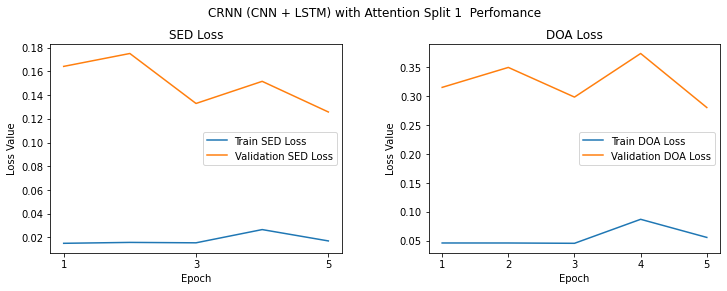

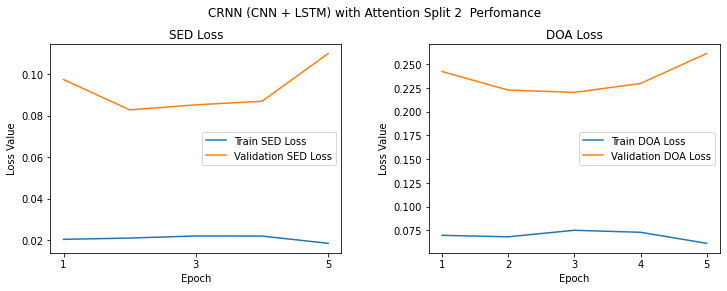

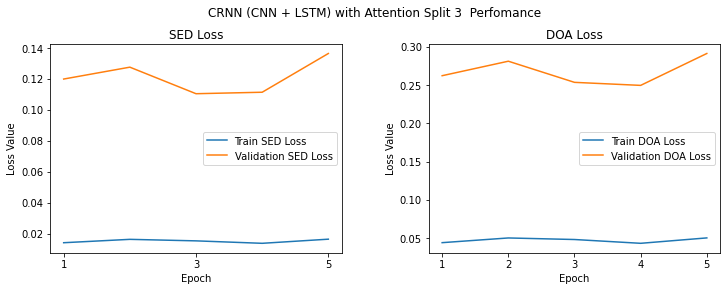

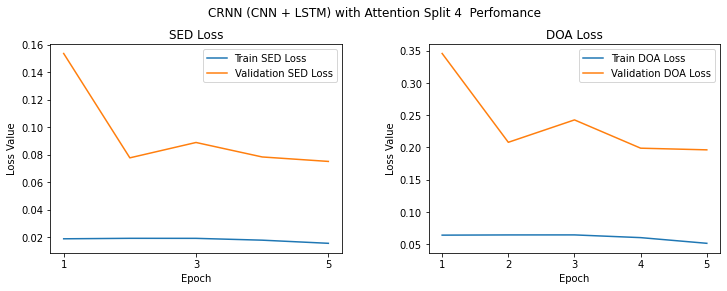

In [16]:
# This experiment uses a CRNN with GRU as its RNN units
# Please excuse the mistake in the names of the training reports
params = get_params("1")
train_crnn(params, True, "gru")

## CNN + LSTM

SET: 1
USING DEFAULT PARAMETERS

	quick_test: False
	dataset_dir: /content/drive/My Drive/Colab Notebooks/Applications of Machine Learning/Assignment/SELD/dataset/
	feat_label_dir: /content/drive/My Drive/Colab Notebooks/Applications of Machine Learning/Assignment/SELD/dataset/feat_label/
	model_dir: /content/drive/My Drive/Colab Notebooks/Applications of Machine Learning/Assignment/SELD/models/
	dcase_output: False
	mode: dev
	dataset: foa
	sequence_length: 128
	batch_size: 16
	dropout_rate: 0
	nb_cnn2d_filt: 64
	f_pool_size: [4, 4, 2]
	t_pool_size: [1, 1, 1]
	rnn_size: [128, 128]
	fnn_size: [128]
	loss_weights: [1.0, 50.0]
	nb_epochs: 10
	epochs_per_fit: 5
	patience: 1


---------------------------------------------------------------------------------------------------
------------------------------------      SPLIT 1   -----------------------------------------------
---------------------------------------------------------------------------------------------------
	Datagen_mode: dev

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



MODEL:
	dropout_rate: 0
	CNN: nb_cnn_filt: 64, f_pool_size[4, 4, 2], t_pool_size[1, 1, 1]
	rnn_size: [128, 128], fnn_size: [128]

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 64, 7)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_12 (Conv2D)             (None, 128, 64, 64)  4096        ['input_5[0][0]']                
                                                                                                  
 batch_normalization_12 (BatchN  (None, 128, 64, 64)  256        ['conv2d_12[0][0]']              
 ormalization)                                              

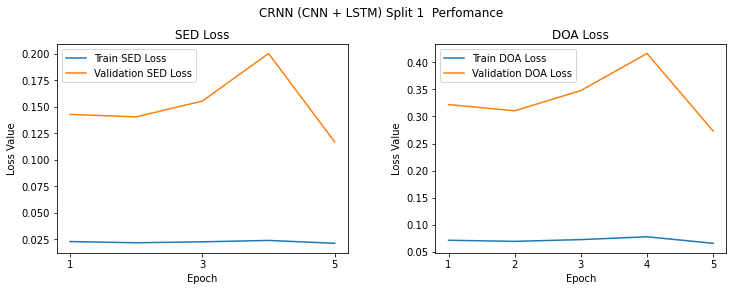

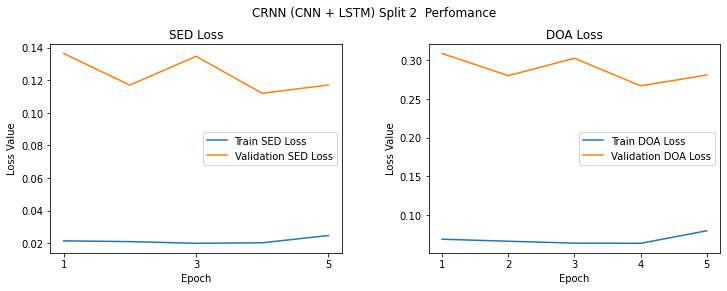

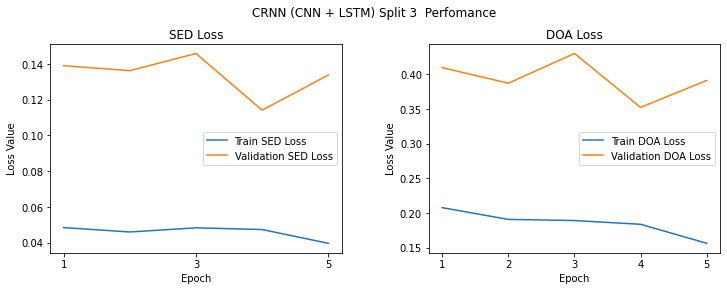

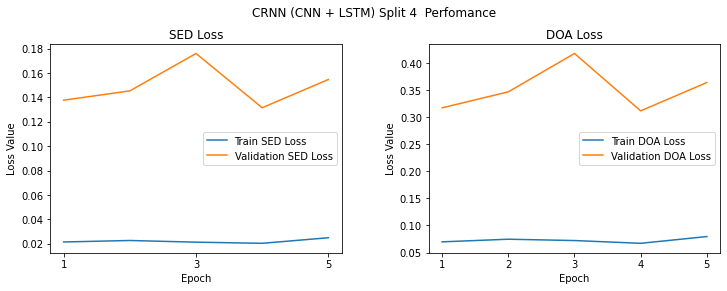

In [18]:
# This experiment uses a CRNN with LSTM as its RNN units
params = get_params("1")
train_crnn(params, True, "lstm")

## CNN + LSTM + Attention in SED and DOA

In [ ]:
# This experiment uses a CRNN with LSTM as its RNN units and the use of Attention in SED and DOA estimations
# The environment ran out of memory so this experiment could not be completed
params = get_params("1")
train_crnn(params, True, "full_attention")

SET: 1
USING DEFAULT PARAMETERS

	quick_test: False
	dataset_dir: /content/drive/My Drive/Colab Notebooks/Applications of Machine Learning/Assignment/SELD/dataset/
	feat_label_dir: /content/drive/My Drive/Colab Notebooks/Applications of Machine Learning/Assignment/SELD/dataset/feat_label/
	model_dir: /content/drive/My Drive/Colab Notebooks/Applications of Machine Learning/Assignment/SELD/models/
	dcase_output: False
	mode: dev
	dataset: foa
	sequence_length: 128
	batch_size: 16
	dropout_rate: 0
	nb_cnn2d_filt: 64
	f_pool_size: [4, 4, 2]
	t_pool_size: [1, 1, 1]
	rnn_size: [128, 128]
	fnn_size: [128]
	loss_weights: [1.0, 50.0]
	nb_epochs: 10
	epochs_per_fit: 5
	patience: 1


---------------------------------------------------------------------------------------------------
------------------------------------      SPLIT 1   -----------------------------------------------
---------------------------------------------------------------------------------------------------
	Datagen_mode: dev

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Streaming output truncated to the last 5000 lines.
                                                                                                  
 tf.expand_dims_436 (TFOpLambda  (16, 1, 128)        0           ['bahdanau_attention_2[216][0]'] 
 )                                                                                                
                                                                                                  
 tf.concat_218 (TFOpLambda)     (16, 1, 150)         0           ['tf.expand_dims_436[0][0]',     
                                                                  'tf.expand_dims_435[0][0]']     
                                                                                                  
 tf.expand_dims_437 (TFOpLambda  (16, 1, 22)         0           ['doa_decoder_dense[88][0]']     
 )                                                                                                
                                                          

## CNN + Attention + LSTM

SET: 1
USING DEFAULT PARAMETERS

	quick_test: False
	dataset_dir: /content/drive/My Drive/Colab Notebooks/Applications of Machine Learning/Assignment/SELD/dataset/
	feat_label_dir: /content/drive/My Drive/Colab Notebooks/Applications of Machine Learning/Assignment/SELD/dataset/feat_label/
	model_dir: /content/drive/My Drive/Colab Notebooks/Applications of Machine Learning/Assignment/SELD/models/
	dcase_output: False
	mode: dev
	dataset: foa
	sequence_length: 128
	batch_size: 16
	dropout_rate: 0
	nb_cnn2d_filt: 64
	f_pool_size: [4, 4, 2]
	t_pool_size: [1, 1, 1]
	rnn_size: [128, 128]
	fnn_size: [128]
	loss_weights: [1.0, 50.0]
	nb_epochs: 10
	epochs_per_fit: 5
	patience: 1


---------------------------------------------------------------------------------------------------
------------------------------------      SPLIT 1   -----------------------------------------------
---------------------------------------------------------------------------------------------------
	Datagen_mode: dev

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



MODEL:
	dropout_rate: 0
	CNN: nb_cnn_filt: 64, f_pool_size[4, 4, 2], t_pool_size[1, 1, 1]
	rnn_size: [128, 128], fnn_size: [128]

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 128, 64, 7)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_39 (Conv2D)             (None, 128, 64, 64)  4096        ['input_14[0][0]']               
                                                                                                  
 batch_normalization_39 (BatchN  (None, 128, 64, 64)  256        ['conv2d_39[0][0]']              
 ormalization)                                             

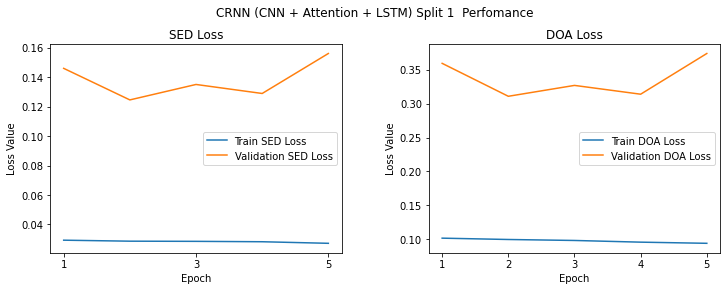

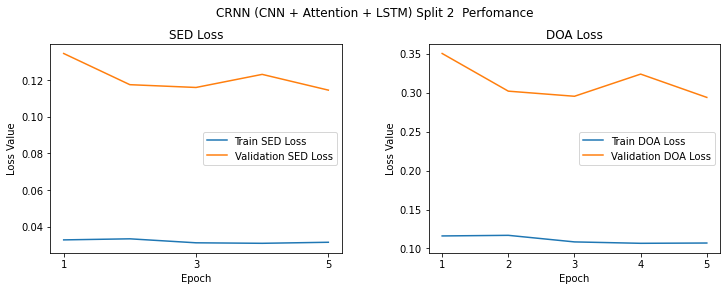

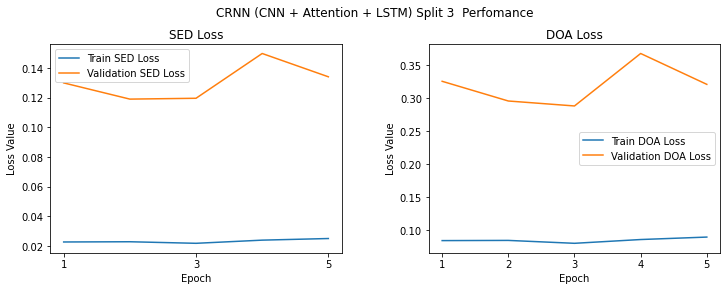

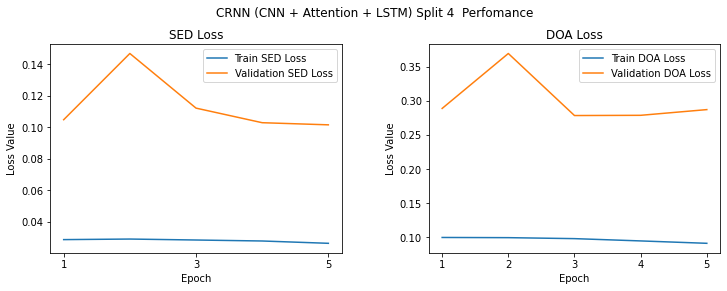

In [27]:
# params (task_id, full_data, model_type)
params = get_params("1")
train_crnn(params, True, "lstm_attention")
# 10 epochs of 5 epochs per fit
# Full data (4 splits)
# CNN with attention before the LSTM RNN

## CNN + Attention + LSTM (30 epochs/1 split)

SET: 4
	quick_test: False
	dataset_dir: /content/drive/My Drive/Colab Notebooks/Applications of Machine Learning/Assignment/SELD/dataset/
	feat_label_dir: /content/drive/My Drive/Colab Notebooks/Applications of Machine Learning/Assignment/SELD/dataset/feat_label/
	model_dir: /content/drive/My Drive/Colab Notebooks/Applications of Machine Learning/Assignment/SELD/models/
	dcase_output: False
	mode: dev
	dataset: foa
	sequence_length: 128
	batch_size: 16
	dropout_rate: 0
	nb_cnn2d_filt: 64
	f_pool_size: [4, 4, 2]
	t_pool_size: [1, 1, 1]
	rnn_size: [128, 128]
	fnn_size: [128]
	loss_weights: [1.0, 50.0]
	nb_epochs: 30
	epochs_per_fit: 5
	patience: 3


---------------------------------------------------------------------------------------------------
------------------------------------      SPLIT 1   -----------------------------------------------
---------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


	Datagen_mode: dev, nb_files: 241, nb_classes:11
	nb_frames_file: 3000, feat_len: 64, nb_ch: 7, label_len:33

	Dataset: foa, split: [3, 4]
	batch_size: 16, seq_len: 128, shuffle: True
	Total batches in dataset: 353
	label_dir: /content/drive/My Drive/Colab Notebooks/Applications of Machine Learning/Assignment/SELD/dataset/feat_label/foa_dev_label
 	feat_dir: /content/drive/My Drive/Colab Notebooks/Applications of Machine Learning/Assignment/SELD/dataset/feat_label/foa_dev_norm

	Datagen_mode: dev, nb_files: 123, nb_classes:11
	nb_frames_file: 3000, feat_len: 64, nb_ch: 7, label_len:33

	Dataset: foa, split: 2
	batch_size: 16, seq_len: 128, shuffle: False
	Total batches in dataset: 180
	label_dir: /content/drive/My Drive/Colab Notebooks/Applications of Machine Learning/Assignment/SELD/dataset/feat_label/foa_dev_label
 	feat_dir: /content/drive/My Drive/Colab Notebooks/Applications of Machine Learning/Assignment/SELD/dataset/feat_label/foa_dev_norm


FEATURES:
	data_in: (16, 7, 128, 64)


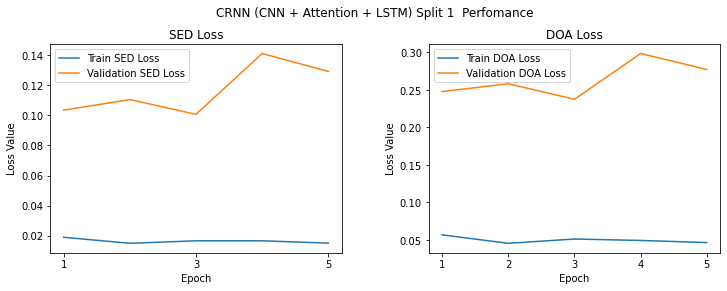

In [12]:
# params (task_id, full_data, model_type)
params = get_params("4")
train_crnn(params, False, "lstm_attention")
# 30 epochs of 5 epochs per fit
# Partial data (1 split)
# CNN with attention before the LSTM RNN

## CNN + LSTM (30 epochs / 1 split)

SET: 4
	quick_test: False
	dataset_dir: /content/drive/My Drive/Colab Notebooks/Applications of Machine Learning/Assignment/SELD/dataset/
	feat_label_dir: /content/drive/My Drive/Colab Notebooks/Applications of Machine Learning/Assignment/SELD/dataset/feat_label/
	model_dir: /content/drive/My Drive/Colab Notebooks/Applications of Machine Learning/Assignment/SELD/models/
	dcase_output: False
	mode: dev
	dataset: foa
	sequence_length: 128
	batch_size: 16
	dropout_rate: 0
	nb_cnn2d_filt: 64
	f_pool_size: [4, 4, 2]
	t_pool_size: [1, 1, 1]
	rnn_size: [128, 128]
	fnn_size: [128]
	loss_weights: [1.0, 50.0]
	nb_epochs: 30
	epochs_per_fit: 5
	patience: 3


---------------------------------------------------------------------------------------------------
------------------------------------      SPLIT 1   -----------------------------------------------
---------------------------------------------------------------------------------------------------
	Datagen_mode: dev, nb_files: 241, nb_classe

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



MODEL:
	dropout_rate: 0
	CNN: nb_cnn_filt: 64, f_pool_size[4, 4, 2], t_pool_size[1, 1, 1]
	rnn_size: [128, 128], fnn_size: [128]

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 64, 7)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_6 (Conv2D)              (None, 128, 64, 64)  4096        ['input_3[0][0]']                
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 128, 64, 64)  256        ['conv2d_6[0][0]']               
 rmalization)                                               

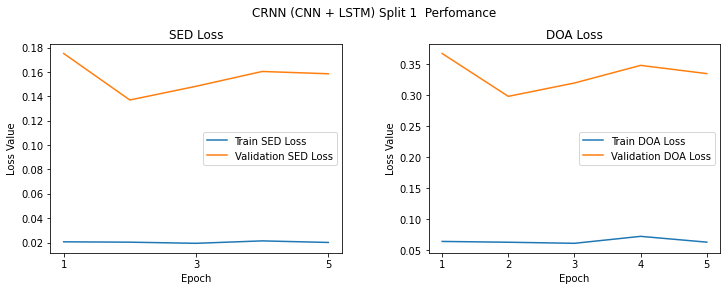

In [14]:
# params (task_id, full_data, model_type)
params = get_params("4")
train_crnn(params, False, "lstm")
# 30 epochs of 5 epochs per fit
# Partial data (1 split)
# CNN with LSTM RNN

## Note
It is important to note that after running the CRNN with and without attention after the CNN layers for 30 epochs of 5 epochs per fit, it is discovered that the CRNN with attention after the CNN layers performs better, therefore we will run further experiments to tune the hyperparameters.

<br></br>
# Hyperparameter Tuning

## Tune CNN Layers
Tuning showed no improvement

SET: 4
	quick_test: False
	dataset_dir: /content/drive/My Drive/Colab Notebooks/Applications of Machine Learning/Assignment/SELD/dataset/
	feat_label_dir: /content/drive/My Drive/Colab Notebooks/Applications of Machine Learning/Assignment/SELD/dataset/feat_label/
	model_dir: /content/drive/My Drive/Colab Notebooks/Applications of Machine Learning/Assignment/SELD/models/
	dcase_output: False
	mode: dev
	dataset: foa
	sequence_length: 128
	batch_size: 16
	dropout_rate: 0
	nb_cnn2d_filt: [64, 64, 64]
	f_pool_size: [4, 4, 2]
	t_pool_size: [1, 1, 1]
	rnn_size: [128, 128]
	fnn_size: [128]
	loss_weights: [1.0, 50.0]
	nb_epochs: 30
	epochs_per_fit: 5
	patience: 3
	task_id: 4


---------------------------------------------------------------------------------------------------
------------------------------------      SPLIT 1   -----------------------------------------------
---------------------------------------------------------------------------------------------------
	Datagen_mode: dev, nb

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



MODEL:
	dropout_rate: 0
	CNN: nb_cnn_filt: [64, 128, 256], f_pool_size[3, 3, 3], t_pool_size[1, 1, 1]
	rnn_size: [128, 128], fnn_size: [128]

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 128, 64, 7)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_31 (Conv2D)             (None, 128, 64, 64)  4096        ['input_10[0][0]']               
                                                                                                  
 batch_normalization_31 (BatchN  (None, 128, 64, 64)  256        ['conv2d_31[0][0]']              
 ormalization)                                  

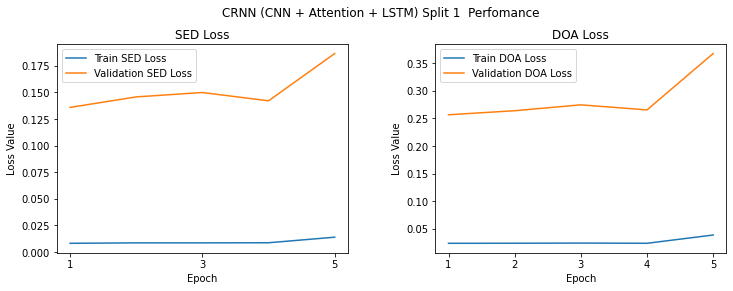

In [29]:
# params 
params = get_params("4")
#params["dropout_rate"] = 0.2
params['nb_cnn2d_filt']=[64, 128, 256] # Number of CNN nodes for each layer
params['f_pool_size']=[3, 3, 3]        # CNN pooling, length of list = number of CNN layers, list value = pooling per layer

train_crnn(params, False, "lstm_attention") # (task_id, full_data, model_type)
# 30 epochs of 5 epochs per fit
# Partial data (1 split)
# CNN with attention before the LSTM RNN


## Tune RNN Layers, FC Layers and Drop out

SET: 4
	quick_test: False
	dataset_dir: /content/drive/My Drive/Colab Notebooks/Applications of Machine Learning/Assignment/SELD/dataset/
	feat_label_dir: /content/drive/My Drive/Colab Notebooks/Applications of Machine Learning/Assignment/SELD/dataset/feat_label/
	model_dir: /content/drive/My Drive/Colab Notebooks/Applications of Machine Learning/Assignment/SELD/models/
	dcase_output: False
	mode: dev
	dataset: foa
	sequence_length: 128
	batch_size: 16
	dropout_rate: 0
	nb_cnn2d_filt: [64, 64, 64]
	f_pool_size: [4, 4, 2]
	t_pool_size: [1, 1, 1]
	rnn_size: [128, 128]
	fnn_size: [128]
	loss_weights: [1.0, 50.0]
	nb_epochs: 30
	epochs_per_fit: 5
	patience: 3
	task_id: 4


---------------------------------------------------------------------------------------------------
------------------------------------      SPLIT 1   -----------------------------------------------
---------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


	Datagen_mode: dev, nb_files: 241, nb_classes:11
	nb_frames_file: 3000, feat_len: 64, nb_ch: 7, label_len:33

	Dataset: foa, split: [3, 4]
	batch_size: 16, seq_len: 128, shuffle: True
	Total batches in dataset: 353
	label_dir: /content/drive/My Drive/Colab Notebooks/Applications of Machine Learning/Assignment/SELD/dataset/feat_label/foa_dev_label
 	feat_dir: /content/drive/My Drive/Colab Notebooks/Applications of Machine Learning/Assignment/SELD/dataset/feat_label/foa_dev_norm

	Datagen_mode: dev, nb_files: 123, nb_classes:11
	nb_frames_file: 3000, feat_len: 64, nb_ch: 7, label_len:33

	Dataset: foa, split: 2
	batch_size: 16, seq_len: 128, shuffle: False
	Total batches in dataset: 180
	label_dir: /content/drive/My Drive/Colab Notebooks/Applications of Machine Learning/Assignment/SELD/dataset/feat_label/foa_dev_label
 	feat_dir: /content/drive/My Drive/Colab Notebooks/Applications of Machine Learning/Assignment/SELD/dataset/feat_label/foa_dev_norm


FEATURES:
	data_in: (16, 7, 128, 64)


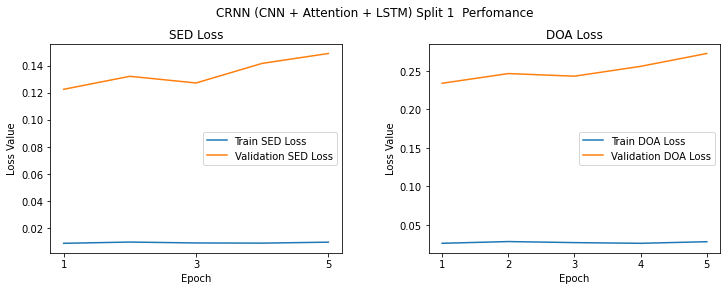

In [14]:
# params 
params = get_params("4")
params['rnn_size']=[256, 256]    # RNN contents, length of list = number of layers, list value = number of nodes
params['fnn_size']=[256, 128]    # Two fully connected layers in the SED and DOA branches with 256 and 128 nodes

train_crnn(params, False, "lstm_attention") # (task_id, full_data, model_type)
# 30 epochs of 5 epochs per fit
# Partial data (1 split)
# CNN with attention before the LSTM RNN

SET: 4
	quick_test: False
	dataset_dir: /content/drive/My Drive/Colab Notebooks/Applications of Machine Learning/Assignment/SELD/dataset/
	feat_label_dir: /content/drive/My Drive/Colab Notebooks/Applications of Machine Learning/Assignment/SELD/dataset/feat_label/
	model_dir: /content/drive/My Drive/Colab Notebooks/Applications of Machine Learning/Assignment/SELD/models/
	dcase_output: False
	mode: dev
	dataset: foa
	sequence_length: 128
	batch_size: 16
	dropout_rate: 0
	nb_cnn2d_filt: [64, 64, 64]
	f_pool_size: [4, 4, 2]
	t_pool_size: [1, 1, 1]
	rnn_size: [128, 128]
	fnn_size: [128]
	loss_weights: [1.0, 50.0]
	nb_epochs: 30
	epochs_per_fit: 5
	patience: 3
	task_id: 4


---------------------------------------------------------------------------------------------------
------------------------------------      SPLIT 1   -----------------------------------------------
---------------------------------------------------------------------------------------------------
	Datagen_mode: dev, nb

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



MODEL:
	dropout_rate: 0
	CNN: nb_cnn_filt: [64, 128, 256], f_pool_size[4, 4, 2], t_pool_size[1, 1, 1]
	rnn_size: [256, 256], fnn_size: [256, 128]

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 64, 7)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_3 (Conv2D)              (None, 128, 64, 64)  4096        ['input_2[0][0]']                
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 128, 64, 64)  256        ['conv2d_3[0][0]']               
 rmalization)                              

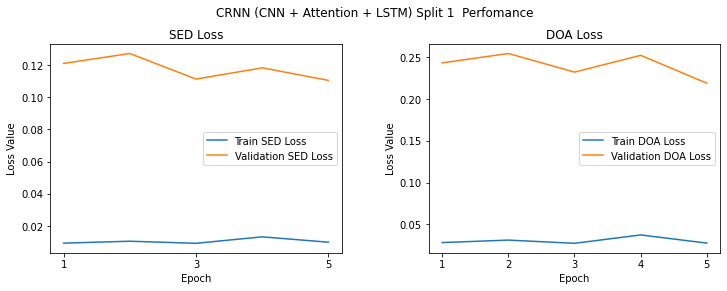

In [15]:
# params 
params = get_params("4")
#params["dropout_rate"] = 0.2
params['nb_cnn2d_filt']=[64, 128, 256] # Number of CNN nodes for each layer
# params['f_pool_size']=[3, 3, 3]        # CNN pooling, length of list = number of CNN layers, list value = pooling per layer
params['rnn_size']=[256, 256]        # RNN contents, length of list = number of layers, list value = number of nodes
params['fnn_size']=[256, 128]

train_crnn(params, False, "lstm_attention") # (task_id, full_data, model_type)
# 30 epochs of 5 epochs per fit
# Partial data (1 split)
# CNN with attention before the LSTM RNN

SET: 4
	quick_test: False
	dataset_dir: /content/drive/My Drive/Colab Notebooks/Applications of Machine Learning/Assignment/SELD/dataset/
	feat_label_dir: /content/drive/My Drive/Colab Notebooks/Applications of Machine Learning/Assignment/SELD/dataset/feat_label/
	model_dir: /content/drive/My Drive/Colab Notebooks/Applications of Machine Learning/Assignment/SELD/models/
	dcase_output: False
	mode: dev
	dataset: foa
	sequence_length: 128
	batch_size: 16
	dropout_rate: 0
	nb_cnn2d_filt: [64, 64, 64]
	f_pool_size: [4, 4, 2]
	t_pool_size: [1, 1, 1]
	rnn_size: [128, 128]
	fnn_size: [128]
	loss_weights: [1.0, 50.0]
	nb_epochs: 30
	epochs_per_fit: 5
	patience: 3
	task_id: 4


---------------------------------------------------------------------------------------------------
------------------------------------      SPLIT 1   -----------------------------------------------
---------------------------------------------------------------------------------------------------
	Datagen_mode: dev, nb

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



MODEL:
	dropout_rate: 0.2
	CNN: nb_cnn_filt: [64, 128, 256], f_pool_size[4, 4, 2], t_pool_size[1, 1, 1]
	rnn_size: [256, 256], fnn_size: [256, 128]

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 64, 7)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_12 (Conv2D)             (None, 128, 64, 64)  4096        ['input_5[0][0]']                
                                                                                                  
 batch_normalization_12 (BatchN  (None, 128, 64, 64)  256        ['conv2d_12[0][0]']              
 ormalization)                           

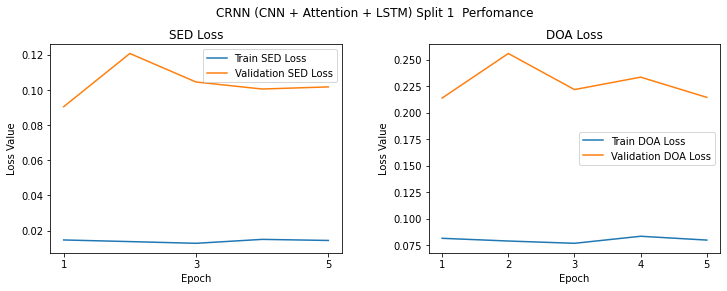

In [20]:
# params 
params = get_params("4")
params["dropout_rate"] = 0.2
params['nb_cnn2d_filt']=[64, 128, 256] # Number of CNN nodes for each layer
# params['f_pool_size']=[3, 3, 3]        # CNN pooling, length of list = number of CNN layers, list value = pooling per layer
params['rnn_size']=[256, 256]        # RNN contents, length of list = number of layers, list value = number of nodes
params['fnn_size']=[256, 128]

train_crnn(params, False, "lstm_attention") # (task_id, full_data, model_type)
# 30 epochs of 5 epochs per fit
# Partial data (1 split)
# CNN with attention before the LSTM RNN

# Final Training based on result of fine tuning

SET: 6
	quick_test: False
	dataset_dir: /content/drive/My Drive/Colab Notebooks/Applications of Machine Learning/Assignment/SELD/dataset/
	feat_label_dir: /content/drive/My Drive/Colab Notebooks/Applications of Machine Learning/Assignment/SELD/dataset/feat_label/
	model_dir: /content/drive/My Drive/Colab Notebooks/Applications of Machine Learning/Assignment/SELD/models/
	dcase_output: False
	mode: dev
	dataset: foa
	sequence_length: 128
	batch_size: 16
	dropout_rate: 0
	nb_cnn2d_filt: [64, 64, 64]
	f_pool_size: [4, 4, 2]
	t_pool_size: [1, 1, 1]
	rnn_size: [128, 128]
	fnn_size: [128]
	loss_weights: [1.0, 50.0]
	nb_epochs: 50
	epochs_per_fit: 5
	patience: 5
	task_id: 6


---------------------------------------------------------------------------------------------------
------------------------------------      SPLIT 1   -----------------------------------------------
---------------------------------------------------------------------------------------------------
	Datagen_mode: dev, nb

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



MODEL:
	dropout_rate: 0.2
	CNN: nb_cnn_filt: [64, 128, 256], f_pool_size[4, 4, 2], t_pool_size[1, 1, 1]
	rnn_size: [256, 256], fnn_size: [256, 128]

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 64, 7)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 128, 64, 64)  4096        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 64, 64)  256        ['conv2d[0][0]']                 
 alization)                                

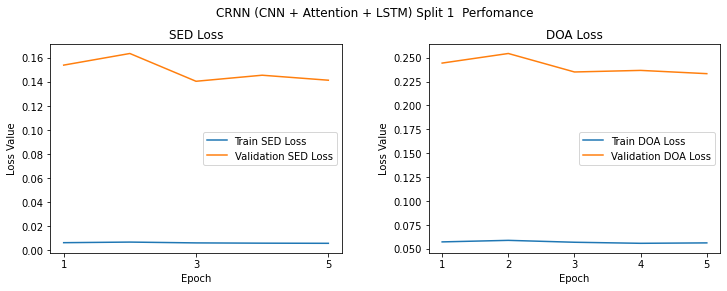

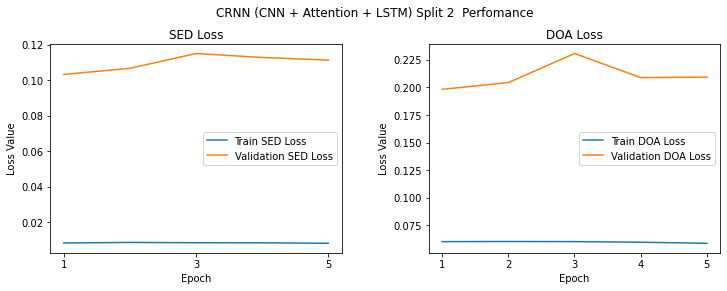

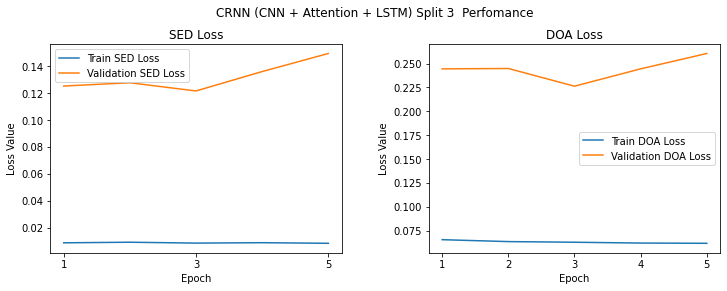

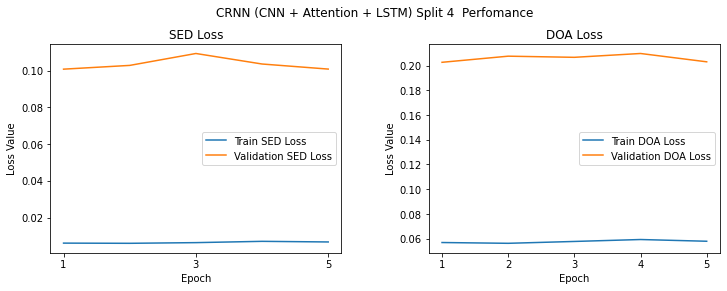

In [13]:
# params 
params = get_params("6")
params["nb_epochs"] = 100
params["patience"] = int (0.1 * params["nb_epochs"]) # 10
params["dropout_rate"] = 0.2
params['nb_cnn2d_filt']=[64, 128, 256] # Number of CNN nodes for each layer
params['rnn_size']=[256, 256]        # RNN contents, length of list = number of layers, list value = number of nodes
params['fnn_size']=[256, 128]        # Two fully connected layers in the SED and DOA branches with 256 and 128 nodes

train_crnn(params, True, "lstm_attention") # (task_id, full_data, model_type)
# 100 epochs of 5 epochs per fit
# patience of 10
# Full data (4 split)
# CNN with attention before the LSTM RNN